In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf

In [2]:
# Check DDF names
from rubin_sim.utils import ddf_locations
ddfs_rough = ddf_locations()
ddf_sn_fieldnames = [f"DD:{k}" for k in ddfs_rough.keys()]
print(ddf_sn_fieldnames)

['DD:ELAISS1', 'DD:XMM_LSS', 'DD:ECDFS', 'DD:COSMOS', 'DD:EDFS_a', 'DD:EDFS_b']


In [3]:
# These are very approximate DDF 10 year depths
jj = maf.scaleBenchmarks(10, 'design')
coadd_depth = maf.calcCoaddedDepth(jj['nvisits'], jj['singleVisitDepth'])
coadd_depth

{'u': 26.08523503375775,
 'g': 27.37886248373993,
 'r': 27.531022278761924,
 'i': 26.831022278761925,
 'z': 26.055149978319907,
 'y': 24.85514997831991}

In [4]:
families = maf.archive.get_family_descriptions('runs_v2.2.json')
family_list = families.index.values
summary_source = 'summary_2022_10_25.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)

In [5]:
ddf_families = [f for f in family_list if f.startswith('ddf')]
for fam in ddf_families:
    print(fam, len(families.loc[fam, 'run']))
ddf_fams = {}
ddf_fams['v2.0'] = ['ddf percent', 'ddf euclid moved']
ddf_fams['v2.1 cadence'] = ['ddf season lengths', 'ddf quad', 'ddf bright', 
                            'ddf quad subfilter', 'ddf accordian', ]
ddf_fams['v2.2 cadence'] = ['ddf season lengths v2', 'ddf quad v2', 'ddf accordian v2', 'ddf desc v2', 'ddf custom v2']
ddf_fams['v2.1 position'] = ['ddf dither', 'ddf old rot']

ddf percent 2
ddf euclid moved 1
ddf season lengths 6
ddf season lengths v2 25
ddf double 6
ddf quad 6
ddf quad v2 5
ddf quad subfilter 6
ddf bright 6
ddf dither 10
ddf old rot 6
ddf accordian 39
ddf accordian v2 39
ddf roll 1
ddf desc 2
ddf early deep 3
ddf desc v2 2
ddf custom v2 1


In [6]:
# Get the metric sets for DDF fields
msets = list(metric_sets.groupby('metric set').first().index)
msets = [m for m in msets if 'DDF' in m]
for k in msets:
    print(k, len(metric_sets.loc[k]))
    # Check that the metrics are correctly named and in the summary file
    summaries.loc[:, metric_sets.loc[k]['metric']]

AGN SF DDF 36
AGN TimeLag 100 days DDF 42
AGN TimeLag 5 days DDF 42
DDF Cadence 54
DDF Depths 41
SNIa DDF 24
SNSL DDF 6


A brief overview of the metric sets, for all DDF simulations. 

(0.3, 1.8)

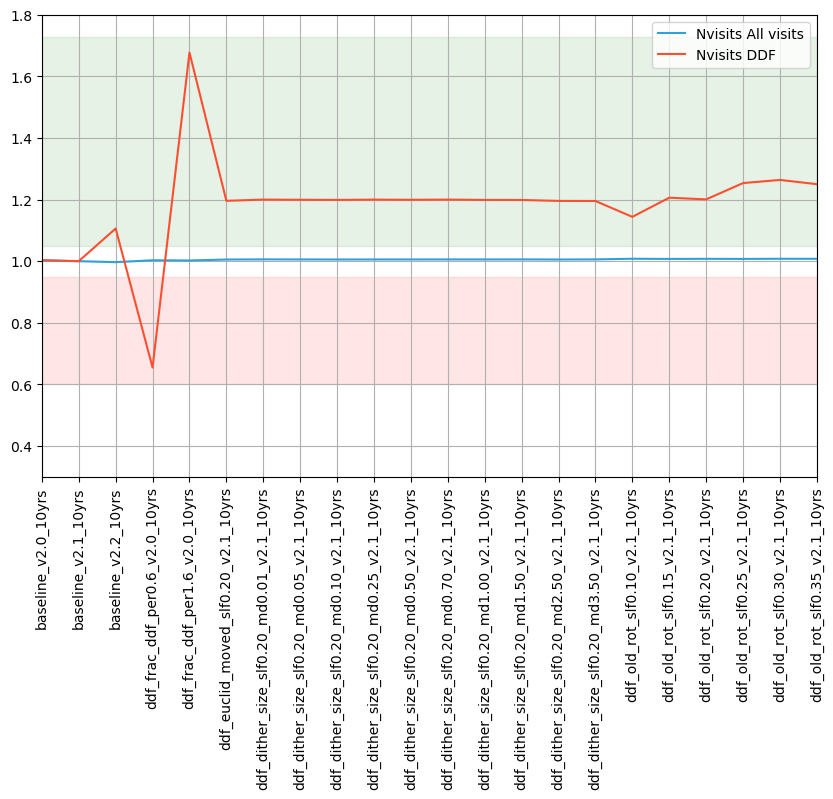

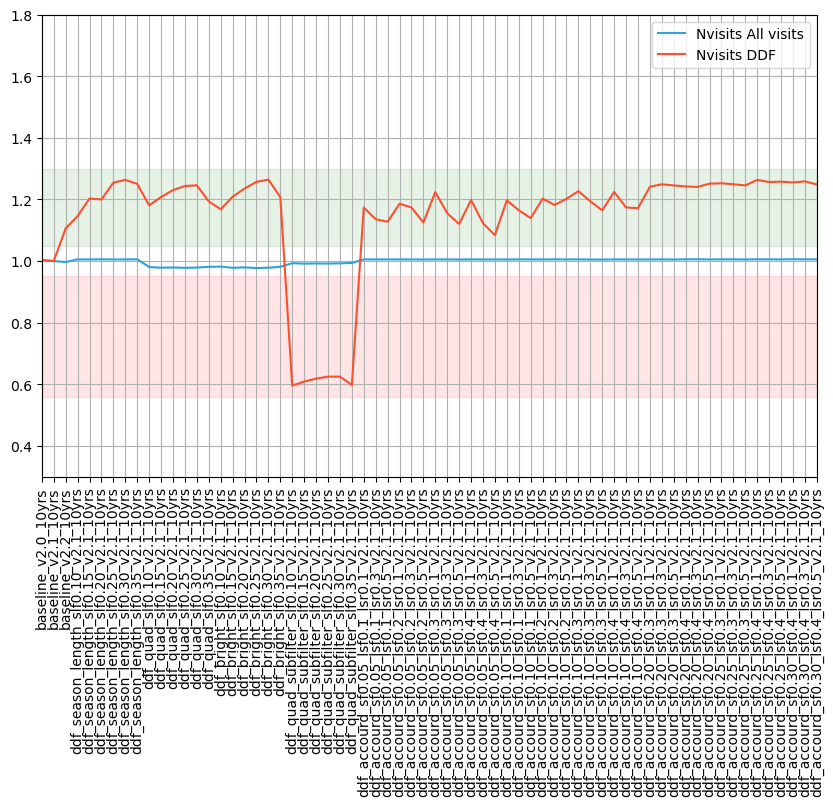

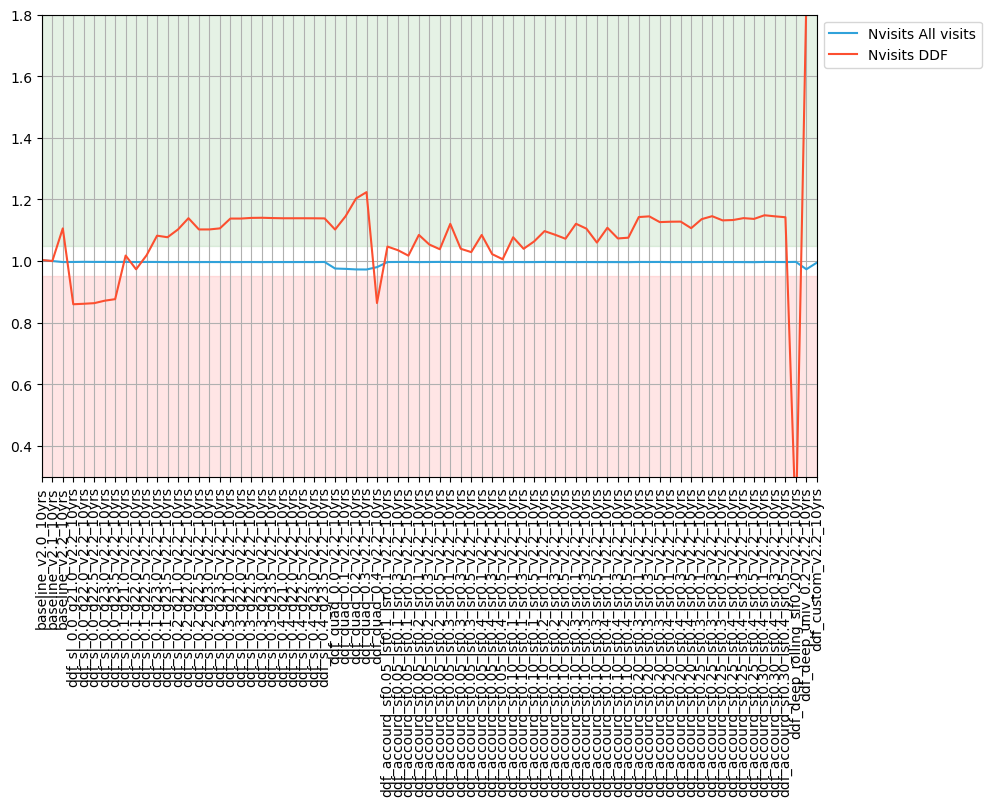

In [7]:
# First let's check the total number of visits in the DDFS, 
# as this has a significant impact on the depths and everything else. 

visits = ['Nvisits All visits', 'Nvisits DDF']
these_runs = np.concatenate([['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'],
                             families.explode('run').loc[ddf_fams['v2.0'] + ddf_fams['v2.1 position'], 'run']])
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, visits],
                             baseline_run='baseline_v2.1_10yrs',
                              linestyles='-',
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             shade_fraction=.05)
ax.set_ylim(0.3, 1.8)

these_runs = np.concatenate([['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'],
                             families.explode('run').loc[ddf_fams['v2.1 cadence'], 'run']])
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, visits],
                             baseline_run='baseline_v2.1_10yrs',
                              linestyles='-',
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             shade_fraction=.05)
ax.set_ylim(0.3, 1.8)

these_runs = np.concatenate([['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'],
                             families.explode('run').loc[ddf_fams['v2.2 cadence'], 'run']])
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, visits],
                             baseline_run='baseline_v2.1_10yrs',
                              linestyles='-',
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             shade_fraction=.05)
ax.set_ylim(0.3, 1.8)

From this we see some general trends, but some explanation of the changes may be needed too. 
The DDF visits in these simulations are (in v2.1 and v2.2) pre-scheduled DDF visits. These pre-scheduled visits use a schedule devised ahead of time, that is based on the lunar cycle and when the field is visible (defining airmass limits, skybrightness limits, etc), to figure out  the "best" times to schedule DDF sequences (visits). When it is time to take a DDF sequence, the scheduler goes ahead and does it right away (it gets top priority at the originally desired/scheduled time). However, if a DDF sequence is missed, then the scheduler no longer prioritizes it -- the sequence could get executed up to 2 days later, but other observations will not avoid it, so if the conditions (airmass limits and skybrightness) define a small window of time, it is very likely to be skipped. The likelihood of a missed DDF sequence being skipped (if originally missed) increases near full moon and towards the edges of the observing season. 

If DDF sequences are scheduled and observed as scheduled, then we would get exactly what we asked for; more often, some sequences are missed. There is accordingly a fudge factor when setting up the DDF prescheduled visits, so that they are slightly "overbooked" in anticipation of missing some. If the fudge factor is not correct, then the overall number of DDF visits will vary as a result. That's where most of this variation in these simulations is coming from.  

(note that there are a few simulations where the requested number of DDF visits is different - these are related to the DESC requests, where there are potentially fewer fields included, although the few that are included are visited at a much higher rate). 

We see that the overall number of visits in the survey tends to hold constant within a few percent, with a few types of DDF strategy (ddf_quad) where there are additional filter changes due to the DDFs so the overall number of visits drops.  

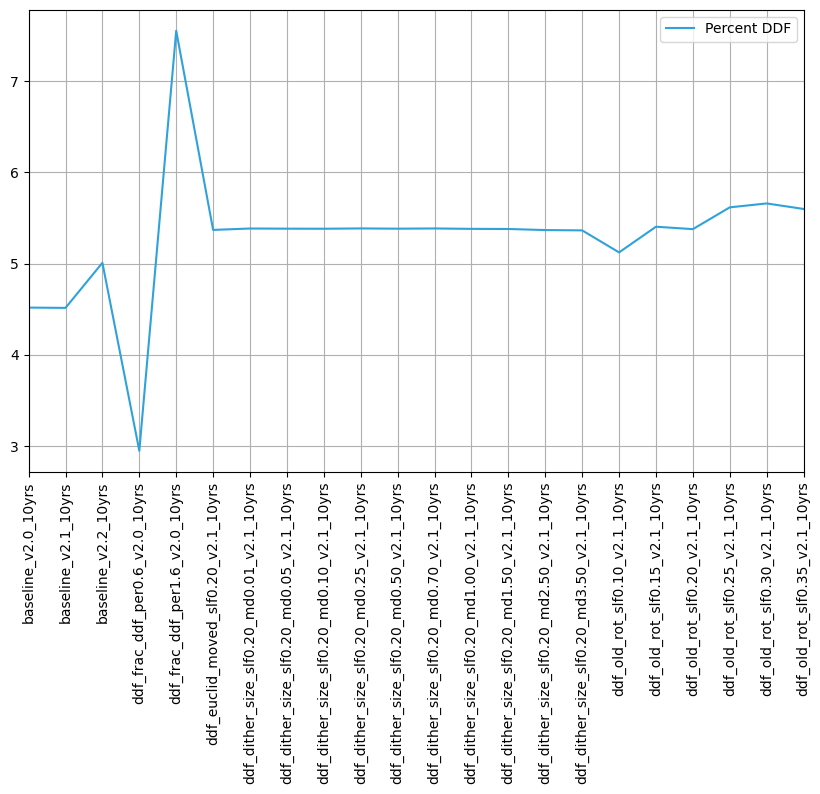

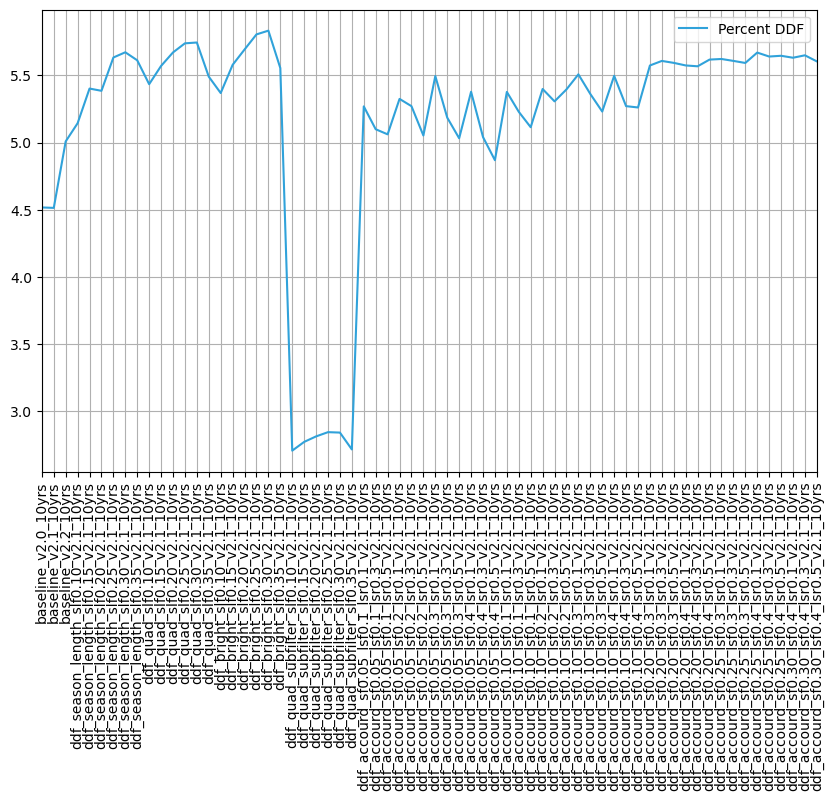

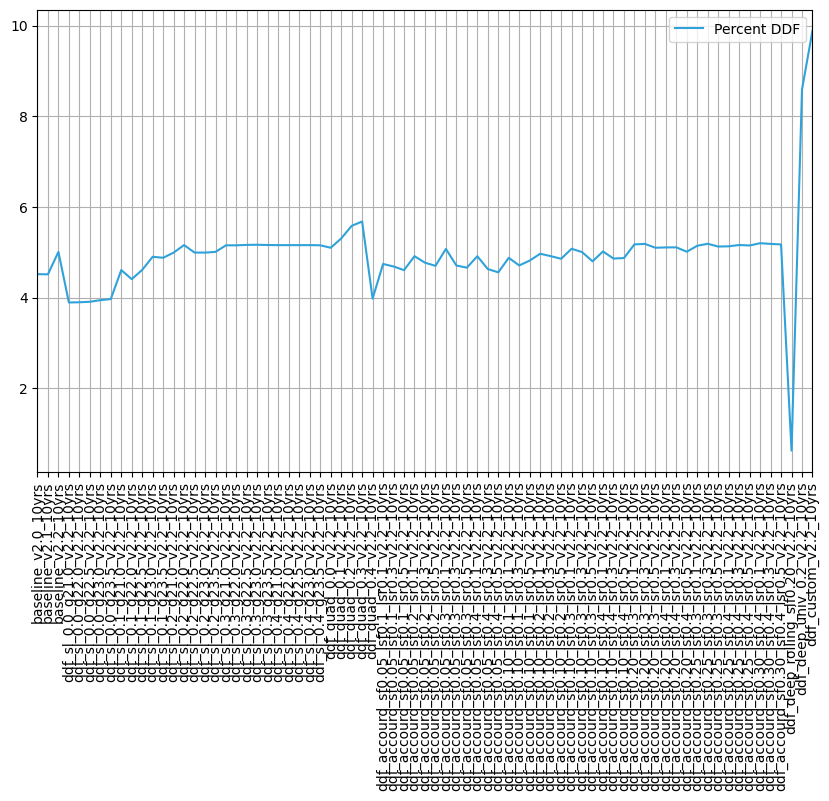

In [8]:
visits = ['Nvisits All visits', 'Nvisits DDF']
val = (summaries.loc[:, 'Nvisits DDF'] / summaries.loc[:, 'Nvisits All visits']) * 100
val = pd.DataFrame(val, columns=['Percent DDF'])

these_runs = np.concatenate([['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'],
                             families.explode('run').loc[ddf_fams['v2.0'] + ddf_fams['v2.1 position'], 'run']])
fig, ax = maf.plot_run_metric(val.loc[these_runs],
                              linestyles='-',
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             shade_fraction=0)

these_runs = np.concatenate([['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'],
                             families.explode('run').loc[ddf_fams['v2.1 cadence'], 'run']])
fig, ax = maf.plot_run_metric(val.loc[these_runs],
                              linestyles='-',
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             shade_fraction=0)

these_runs = np.concatenate([['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'],
                             families.explode('run').loc[ddf_fams['v2.2 cadence'], 'run']])
fig, ax = maf.plot_run_metric(val.loc[these_runs],
                              linestyles='-',
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             shade_fraction=0)

Translating this to "percent" of overall survey time, most runs hang out between 4-5.5 % of the overall time.

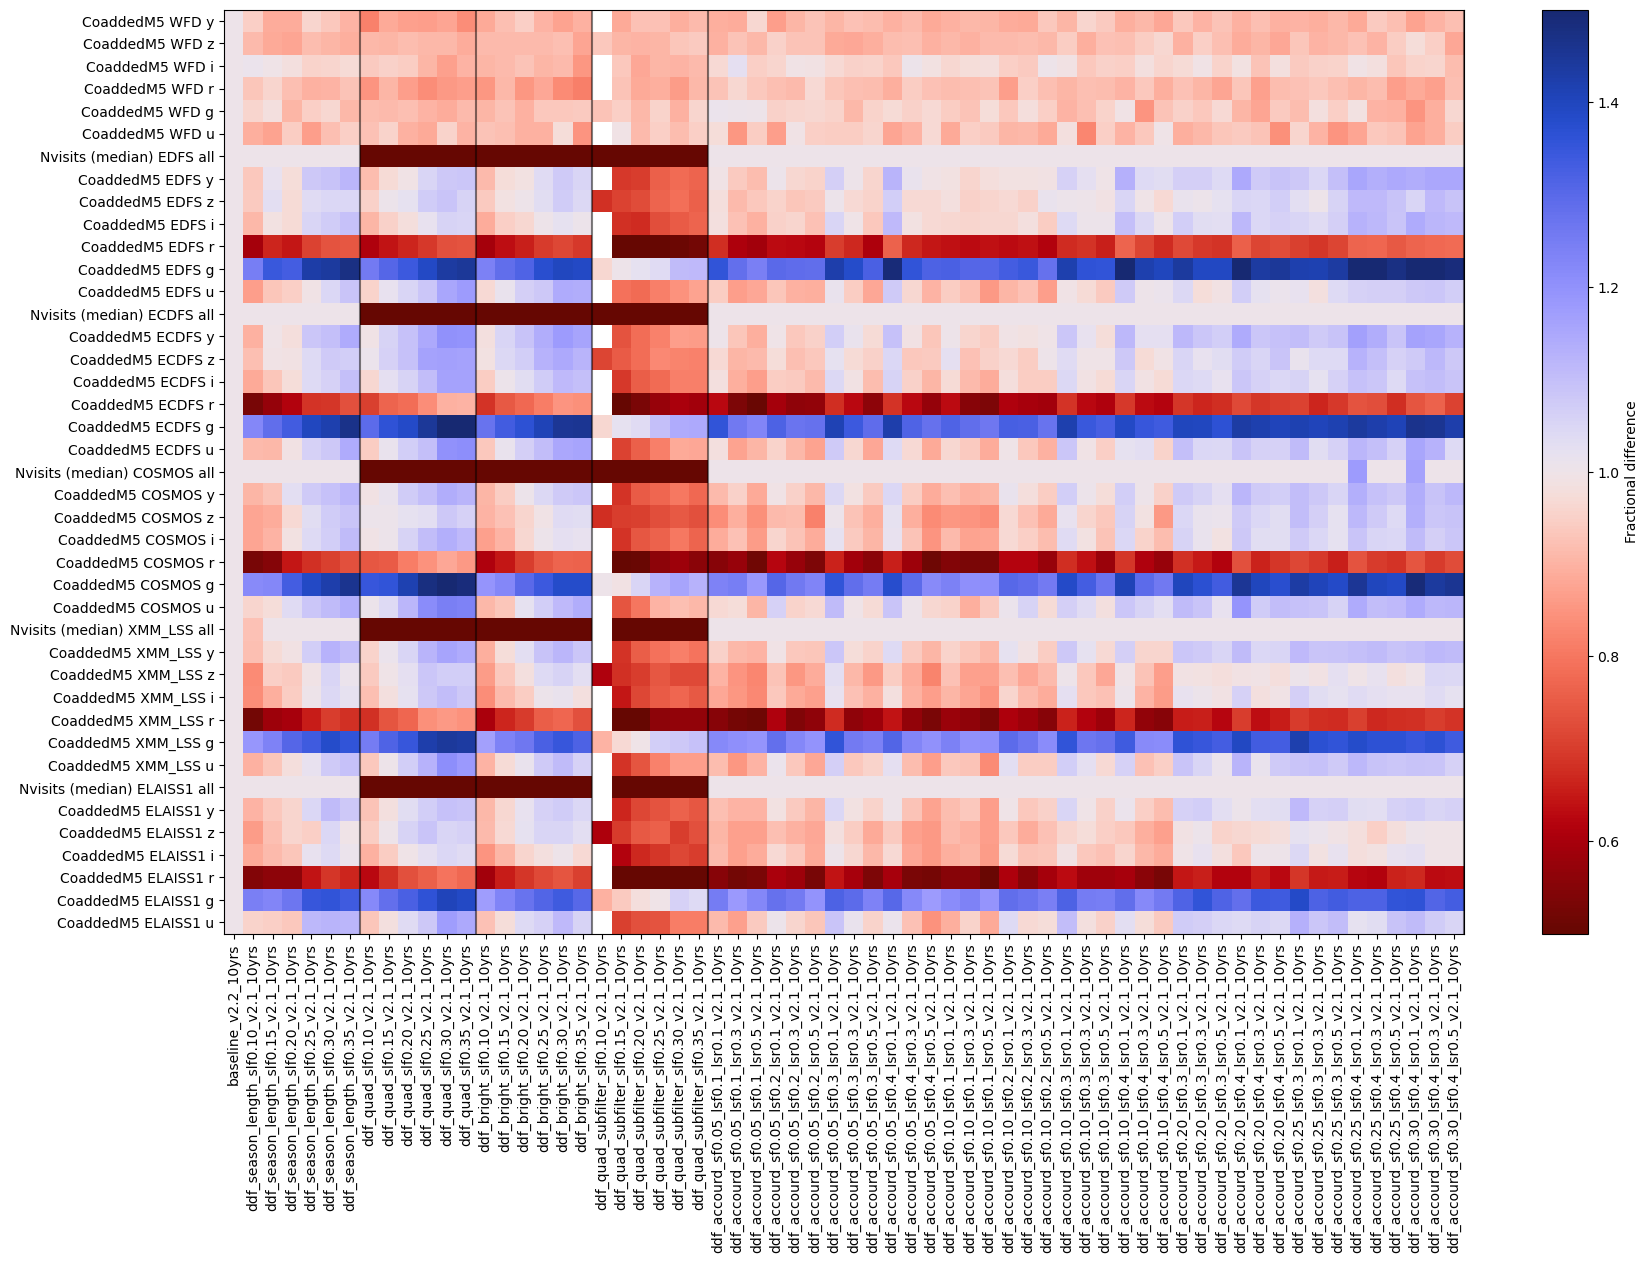

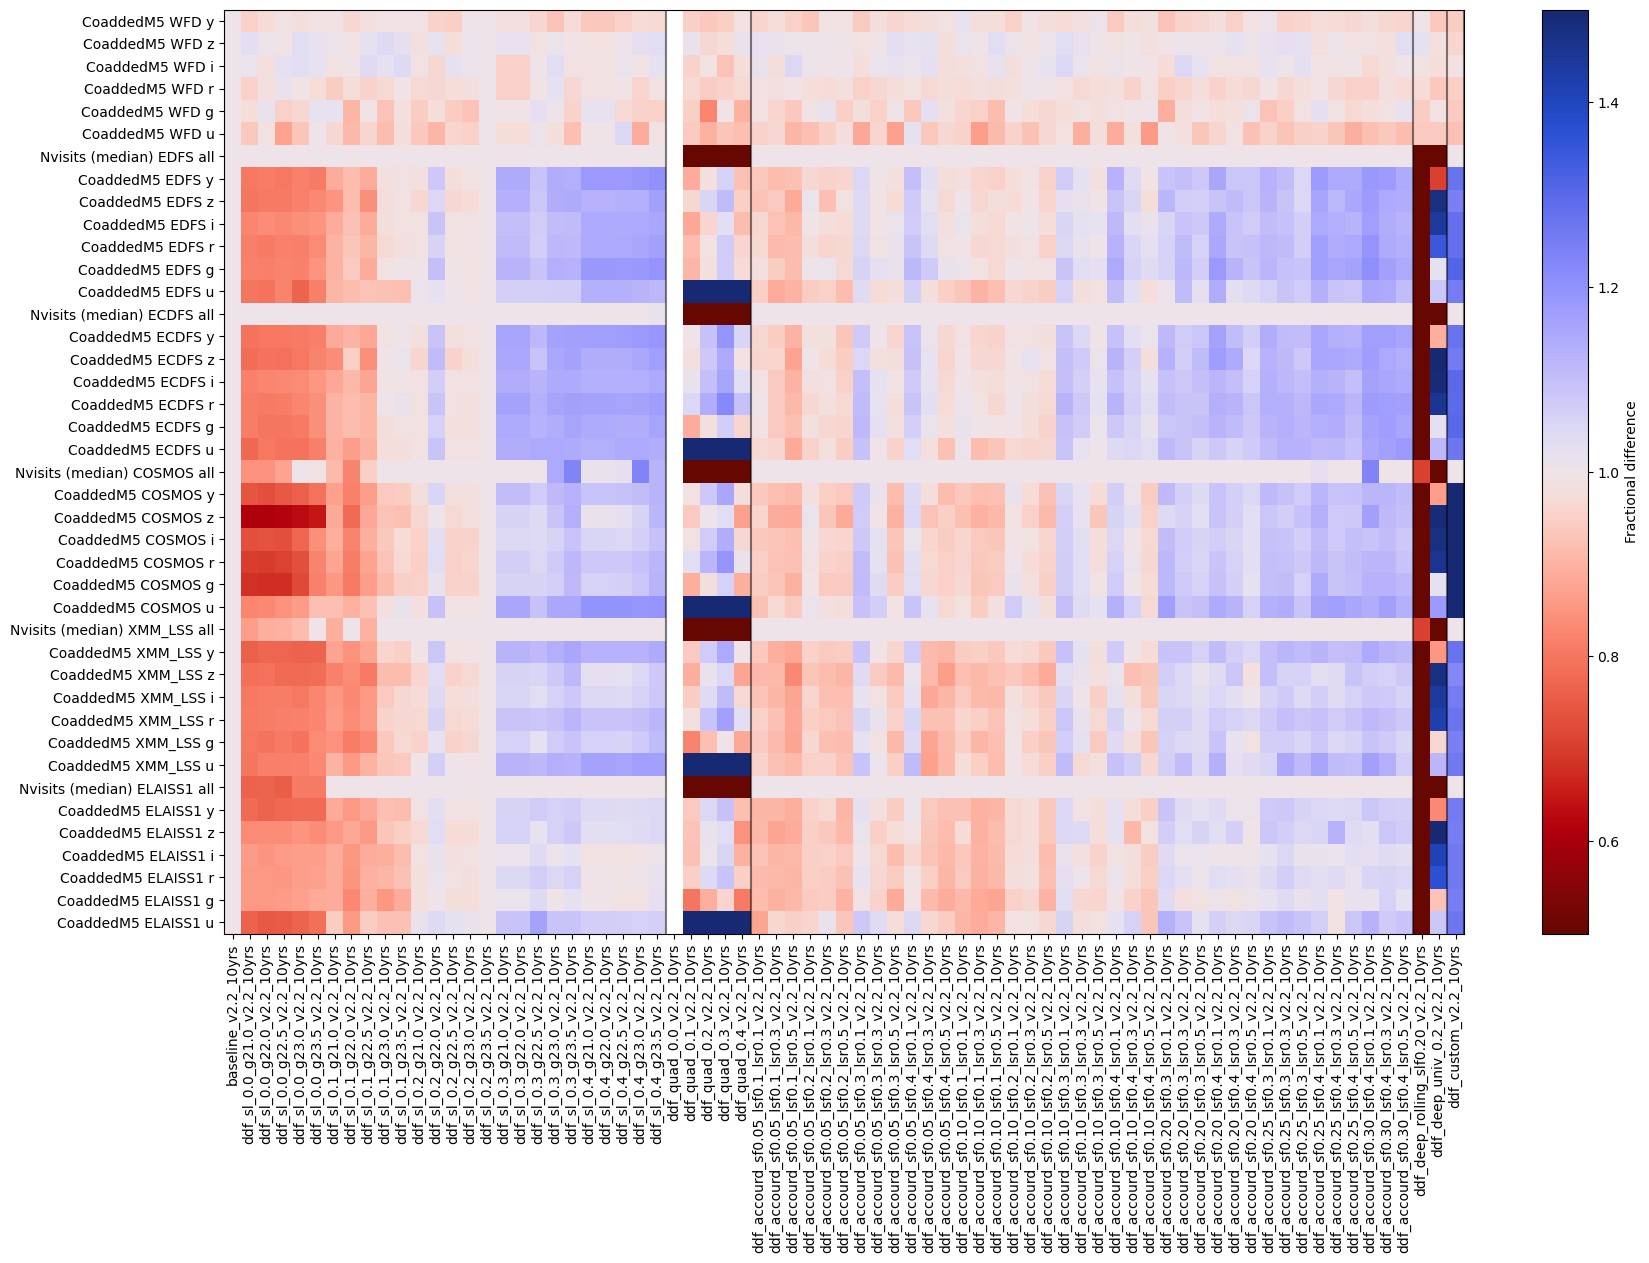

In [9]:
# Let's check out the depths in the DDFs -- v2.1 and v2.2 had difference *sequences* 
# the v2.1 sequences were unintentionally heavy on g band, instead of r band. This was reversed in v2.2 
# We should also see the number of visits in the DDF effects described above. 

baseline = 'baseline_v2.2_10yrs'  # Normalize to the same values in each set
fams = ddf_fams['v2.1 cadence']

these_runs = np.concatenate([[baseline], families.explode('run').loc[fams, 'run']])

for m in ['DDF Depths']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)
    
    lines = maf.find_family_lines(families, fams)
    lines = lines + 1
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
fams = ddf_fams['v2.2 cadence']

these_runs = np.concatenate([[baseline], families.explode('run').loc[fams, 'run']])

for m in ['DDF Depths']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)
    
    lines = maf.find_family_lines(families, fams)
    lines = lines + 1
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)

First, we do see the changes in overall number of DDF visits, and these holding generally closer to the baseline values in v2.2 than in v2.1. 

Second, we see the expected impact of the sequences in v2.1 having more g band observations than r band, so that g is deeper and r is fainter than the baseline. 

The trends across the families with season length are relatively easier to follow - the number of runs is larger in v2.2 than in v2.1, but both show a trend that as the season length ("sl" or "slf" number) increases, the coadded depth decreases. This is because late or early season visits are likely acquired at higher airmasses, but also because in the edges of the season, sequences are more likely to not be 'recoverable' if they are not acquired at the optimal time. This can be seen in the decrease in overall number of visits with longer season length. Likewise, the opposite occurs as the season length is compressed.  Within each season length, the gap around full moon is also varied in v2.2, becoming longer as the requirement on the 5sigma depth required in the images increases ("g" value increases). 

Next is a series of "quad" runs (in v2.2; v2.1 had some additional experiments of quads with different 5sigma depth requirements and subfilter splits). In each of these experiments, the DDF sequence is split up into shorter but more frequent sets of visits. In general these show the same trend with season length, along one of the v2.2 short season runs also missed a lot of visits resulting in less depth. The overall number of visits is slightly fewer, as these are less efficient for scheduling so fewer are added. 

The final large set of runs are the accordian cadence series. These take a season and split it into a 'middle' and two 'shoulders' - the shoulders operate at a reduced rate. The season length is still varied ("sf" here - larger is a shorter season), and the amount of time spent in the low / shoulder part of the season is also varied ("lsf" - again, larger numbers implies a shorter 'high' season) as well as the rate of visits during the low season ("lsr" - larger numbers mean more visits during the low season). The total number of visits is mostly conserved across the entire season, so an accordian cadence with a long season but long low season and low low season rate can still have a fairly high rate of sequences during the high part of the season. Again we see shorter seasons correspond with deeper coadded depths, and within each of these there is some trend for higher coadded depths as more visits are concentrated into a shorter high season.

The last few runs in v2.2 are special runs for the DESC (deep rolling and deep universal/deep u) which are described in the DESC white paper. 

The final run in v2.2 is "ddf_custom_v2.2_10yrs", which increases the overall time spent in the DDFs and also adds a 10year depth to COSMOS in the first 3 years (then continues observing COSMOS as a normal DDF - essentially corresponding to 6 total DDF commitments). Note that the draft v2.99 runs also follow a similar strategy, although with a more conservative 5-7.5% of time spent on the DDFs.

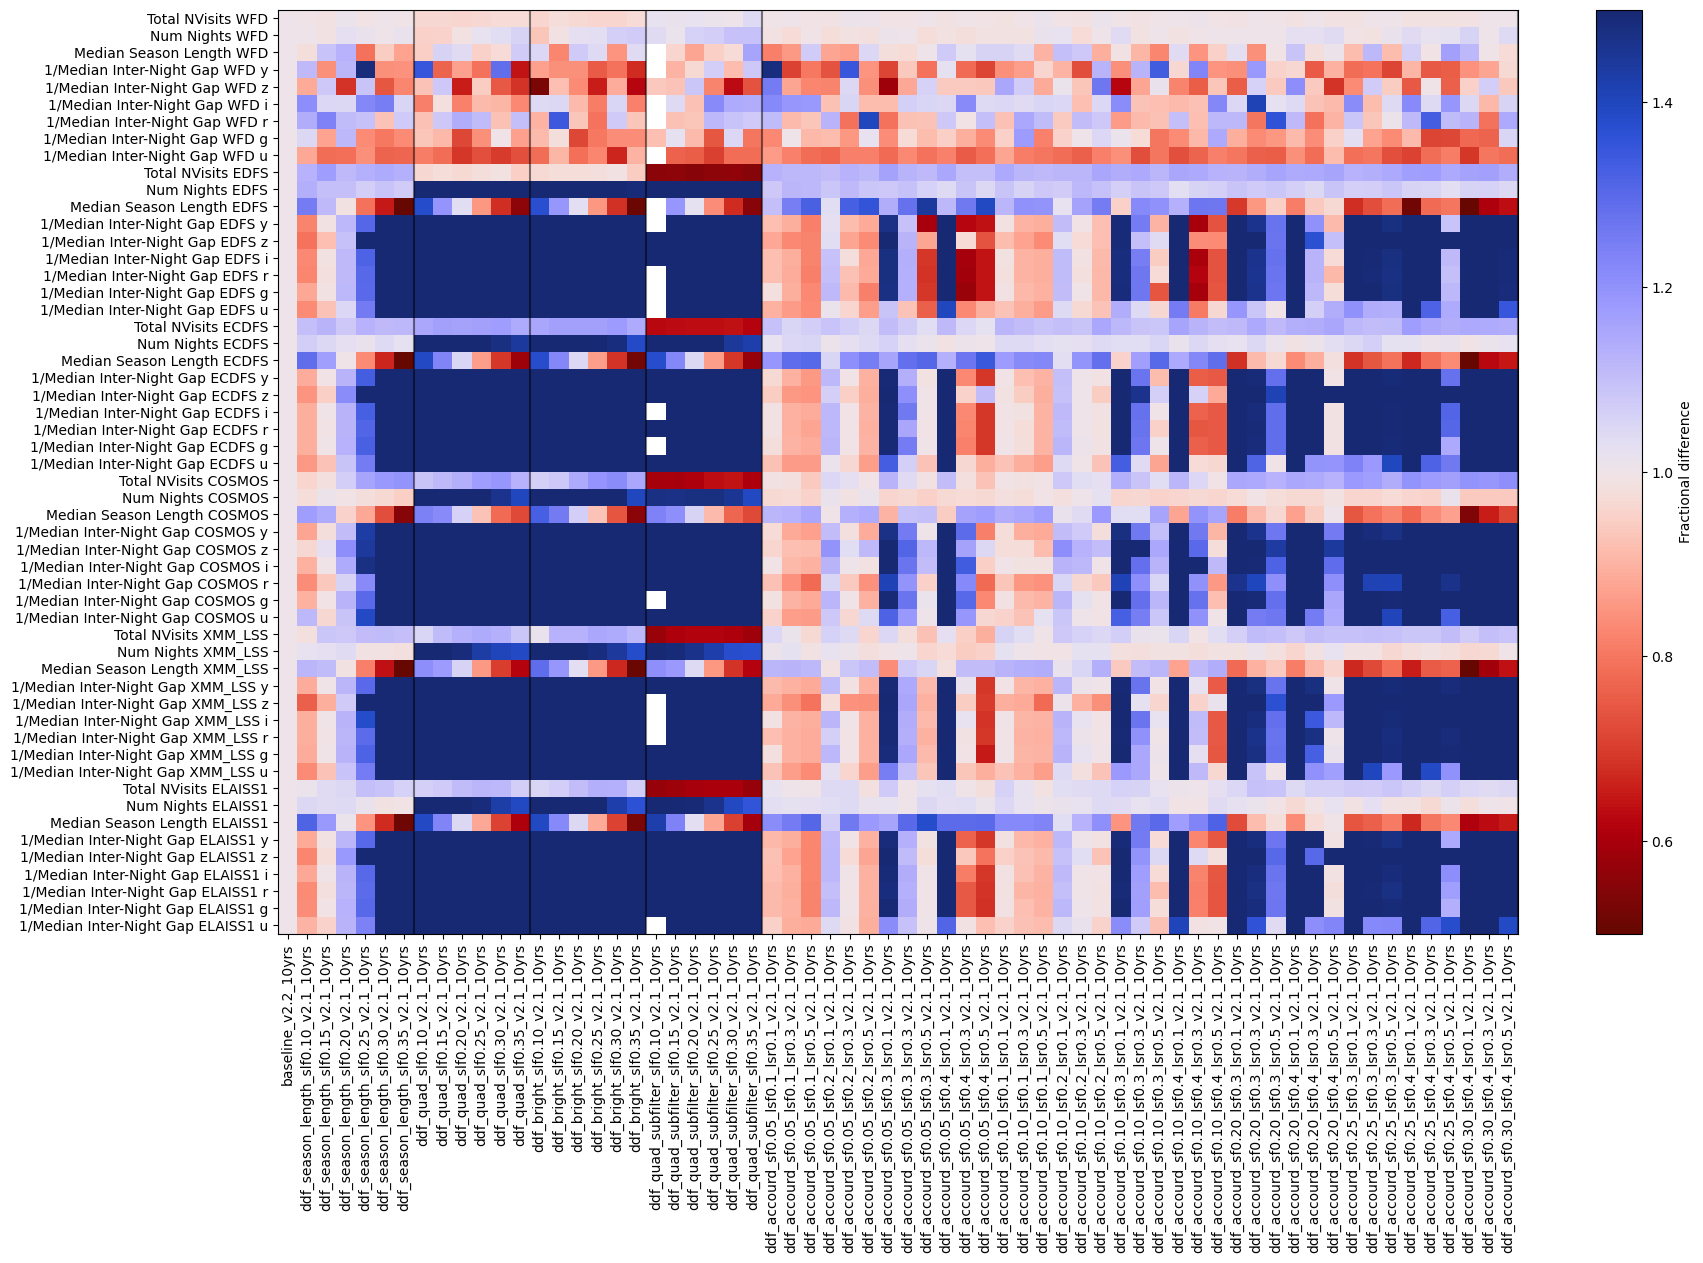

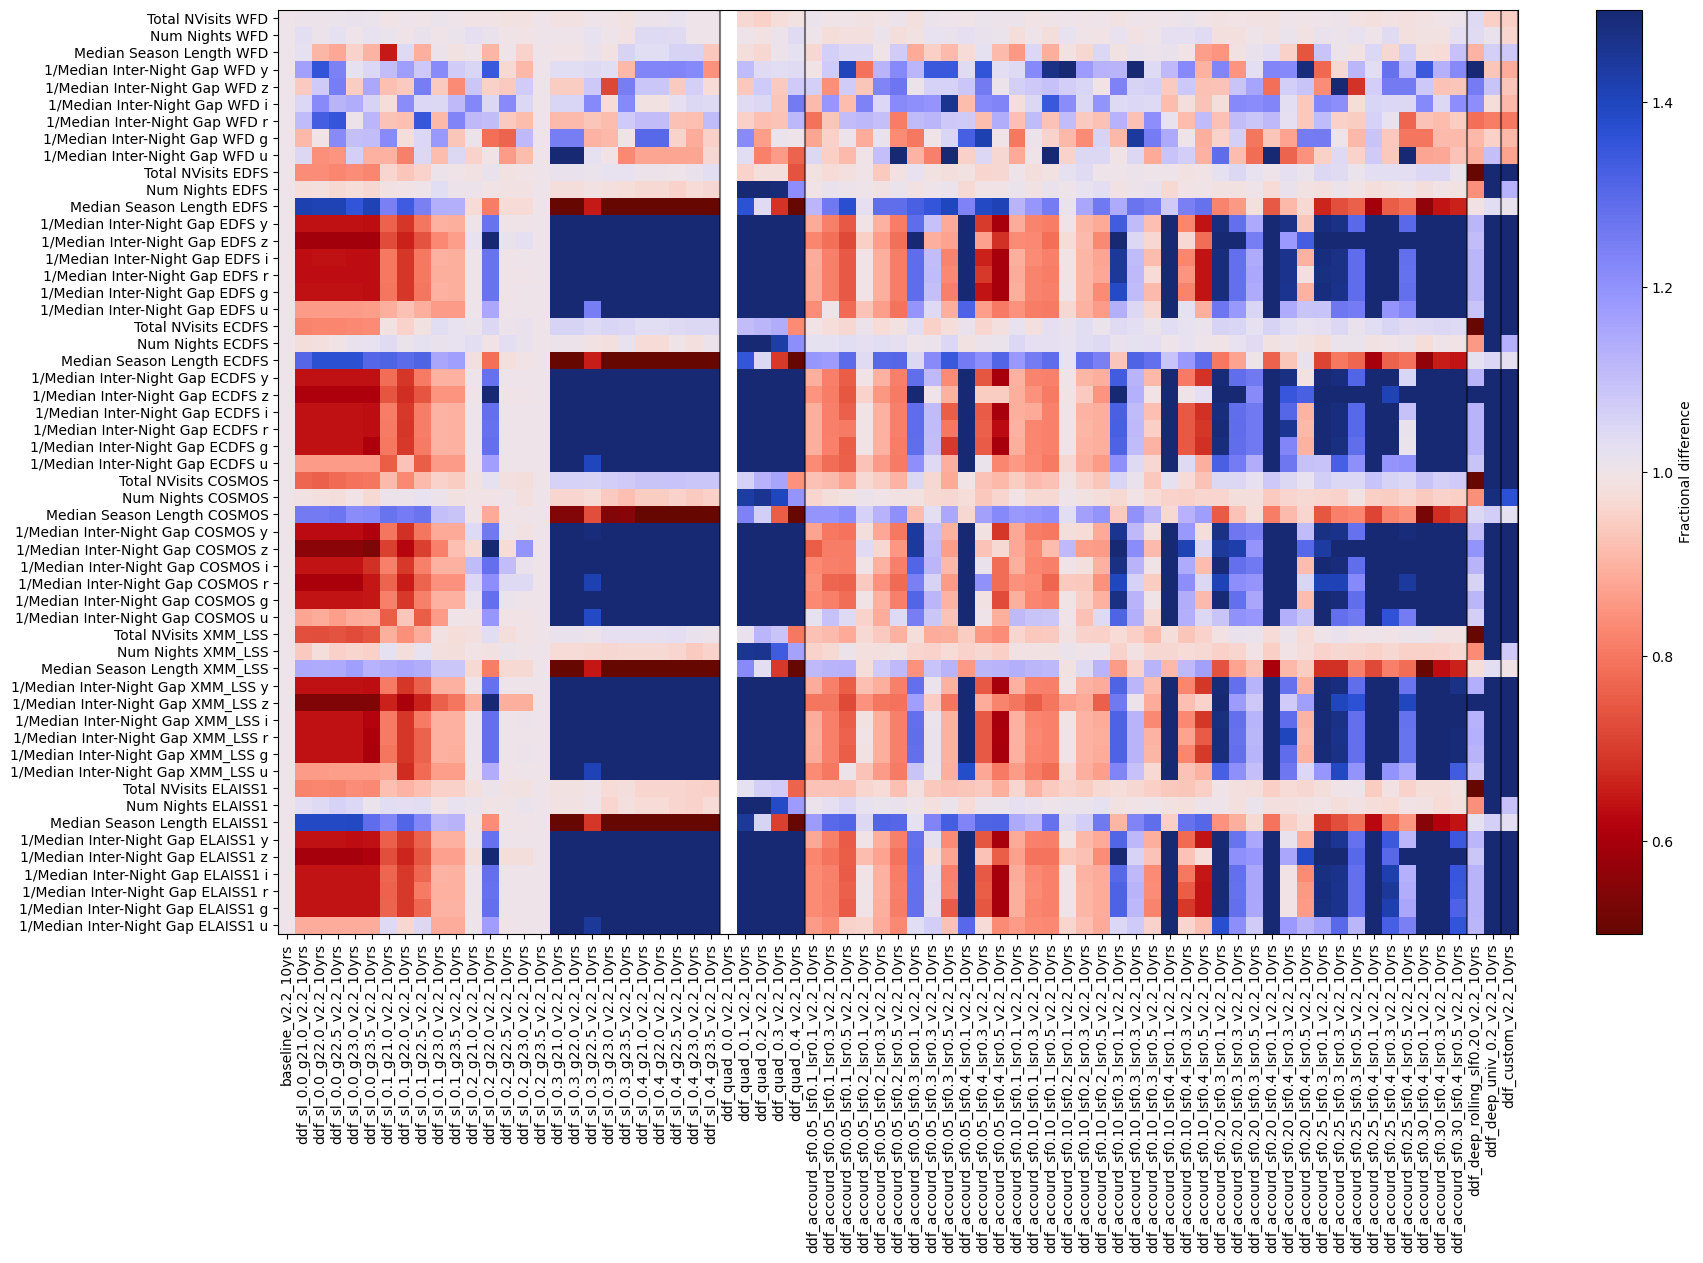

In [10]:
baseline = 'baseline_v2.2_10yrs'  # Normalize to the same values in each set
fams = ddf_fams['v2.1 cadence']

these_runs = np.concatenate([[baseline], families.explode('run').loc[fams, 'run']])

for m in ['DDF Cadence']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)
    
    lines = maf.find_family_lines(families, fams)
    lines = lines + 1
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
fams = ddf_fams['v2.2 cadence']

these_runs = np.concatenate([[baseline], families.explode('run').loc[fams, 'run']])

for m in ['DDF Cadence']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)
    
    lines = maf.find_family_lines(families, fams)
    lines = lines + 1
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)

The cadence responds approximately as you'd expect. As the season length gets longer, the time between visits gets shorter. The accordian cadences beat this a small amount, but typically the shoulders of the season are small compared to the majority of the season (visible exceptions where the low season fraction is large, such as 0.3 or 0.4, and the low season rate is low like 0.1).

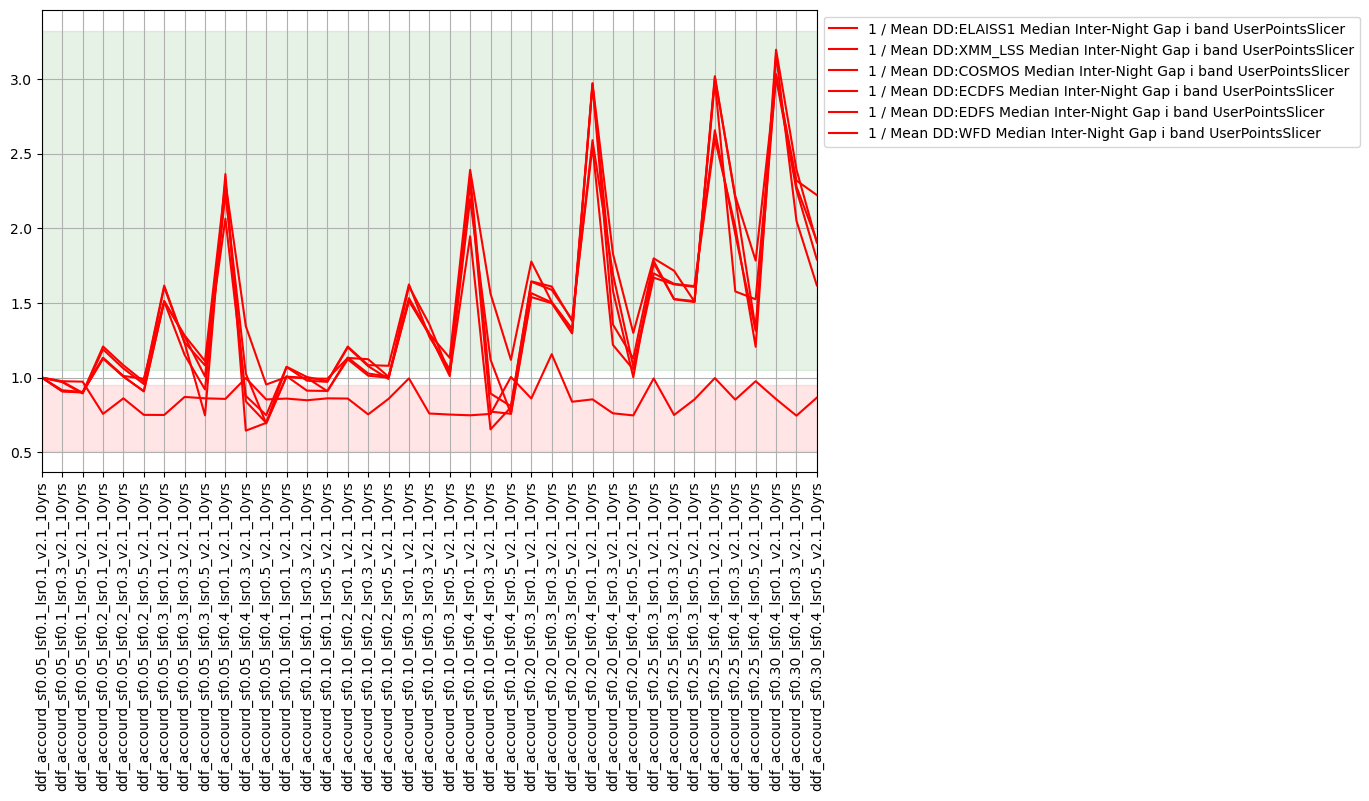

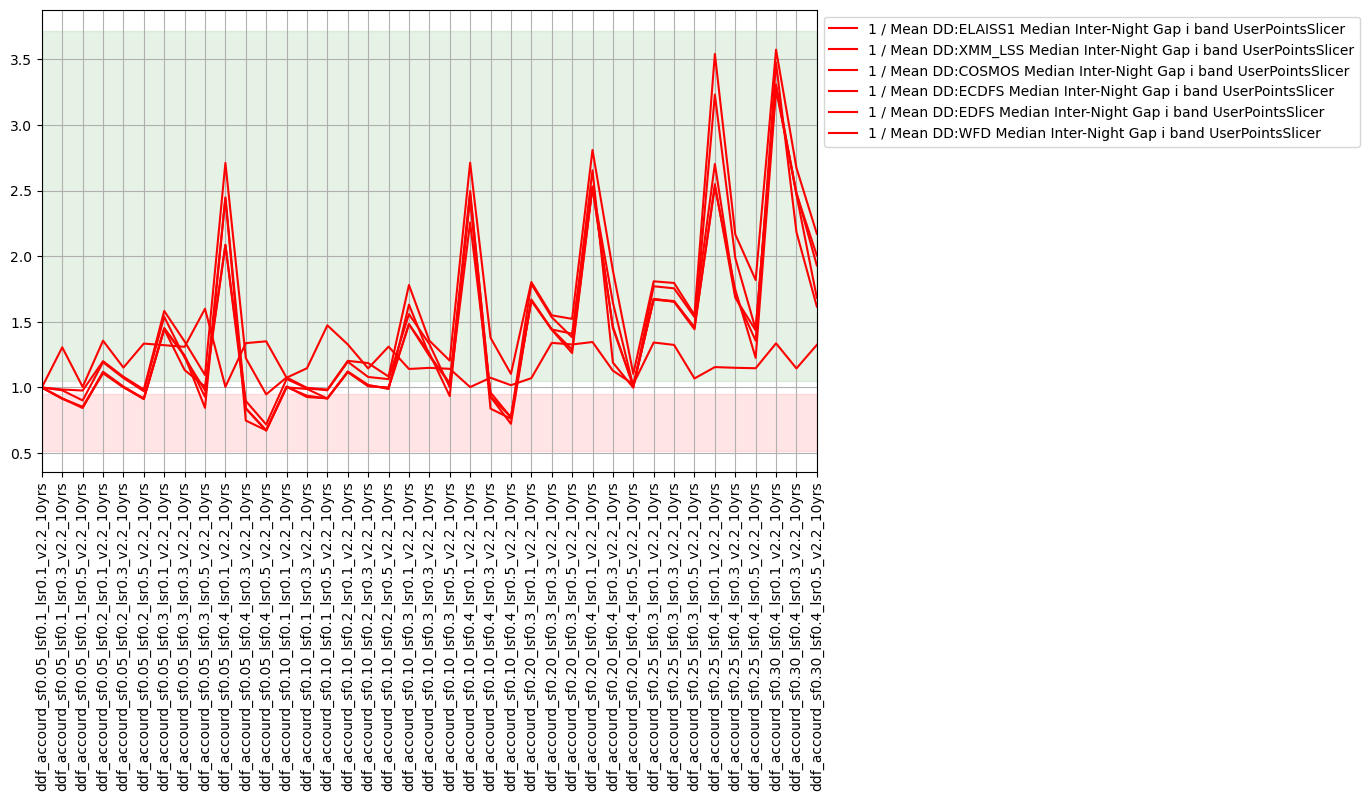

In [11]:
r1 = [r for r in families.explode('run').loc[ddf_fams['v2.1 cadence'], 'run'].values if 'accourd' in r]
r2 = [r for r in families.explode('run').loc[ddf_fams['v2.2 cadence'], 'run'].values if 'accourd' in r]

msub1 = metric_sets.loc[m].query('metric.str.contains("Median Inter-Night Gap") and metric.str.contains(" i")',
                                  engine='python')
msub2 = metric_sets.loc[m].query('metric.str.contains("NVisits all bands") or metric.str.contains("Median Season Length")',
                                  engine='python')
msub = pd.concat([msub1, msub2])
msub = msub1
fig, ax = maf.plot_run_metric(summaries.loc[r1, msub['metric']],
                             baseline_run=r1[0], 
                             metric_set = msub,
                             horizontal_quantity='run',
                             vertical_quantity='value')

fig, ax = maf.plot_run_metric(summaries.loc[r2, msub['metric']],
                             baseline_run=r2[0], 
                             metric_set = msub,
                             horizontal_quantity='run',
                             vertical_quantity='value')

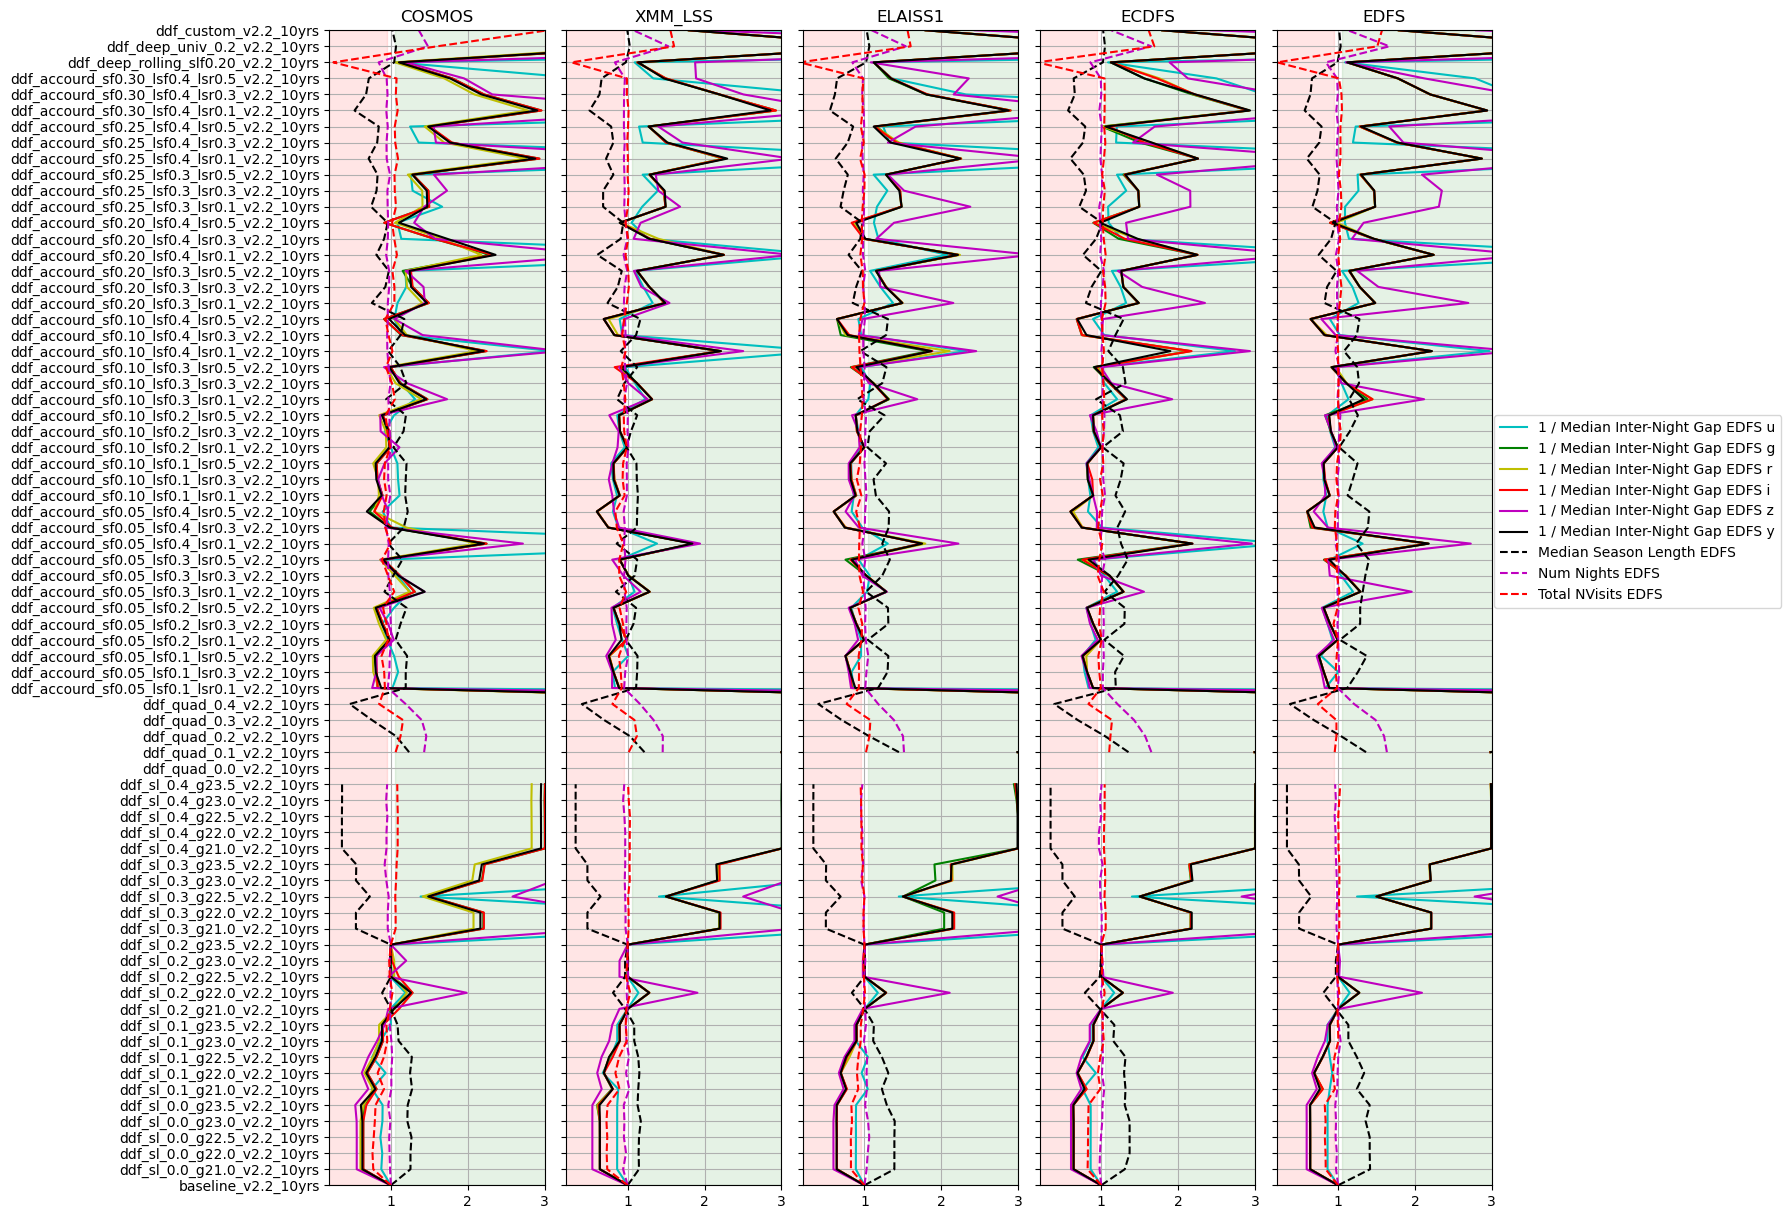

In [12]:
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']

these_runs = np.concatenate([['baseline_v2.2_10yrs'], 
                             #families.explode('run').loc[ddf_fams['v2.1 cadence'], 'run'],
                             families.explode('run').loc[ddf_fams['v2.2 cadence'], 'run']])
                                                         

fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = metrics.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 3)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

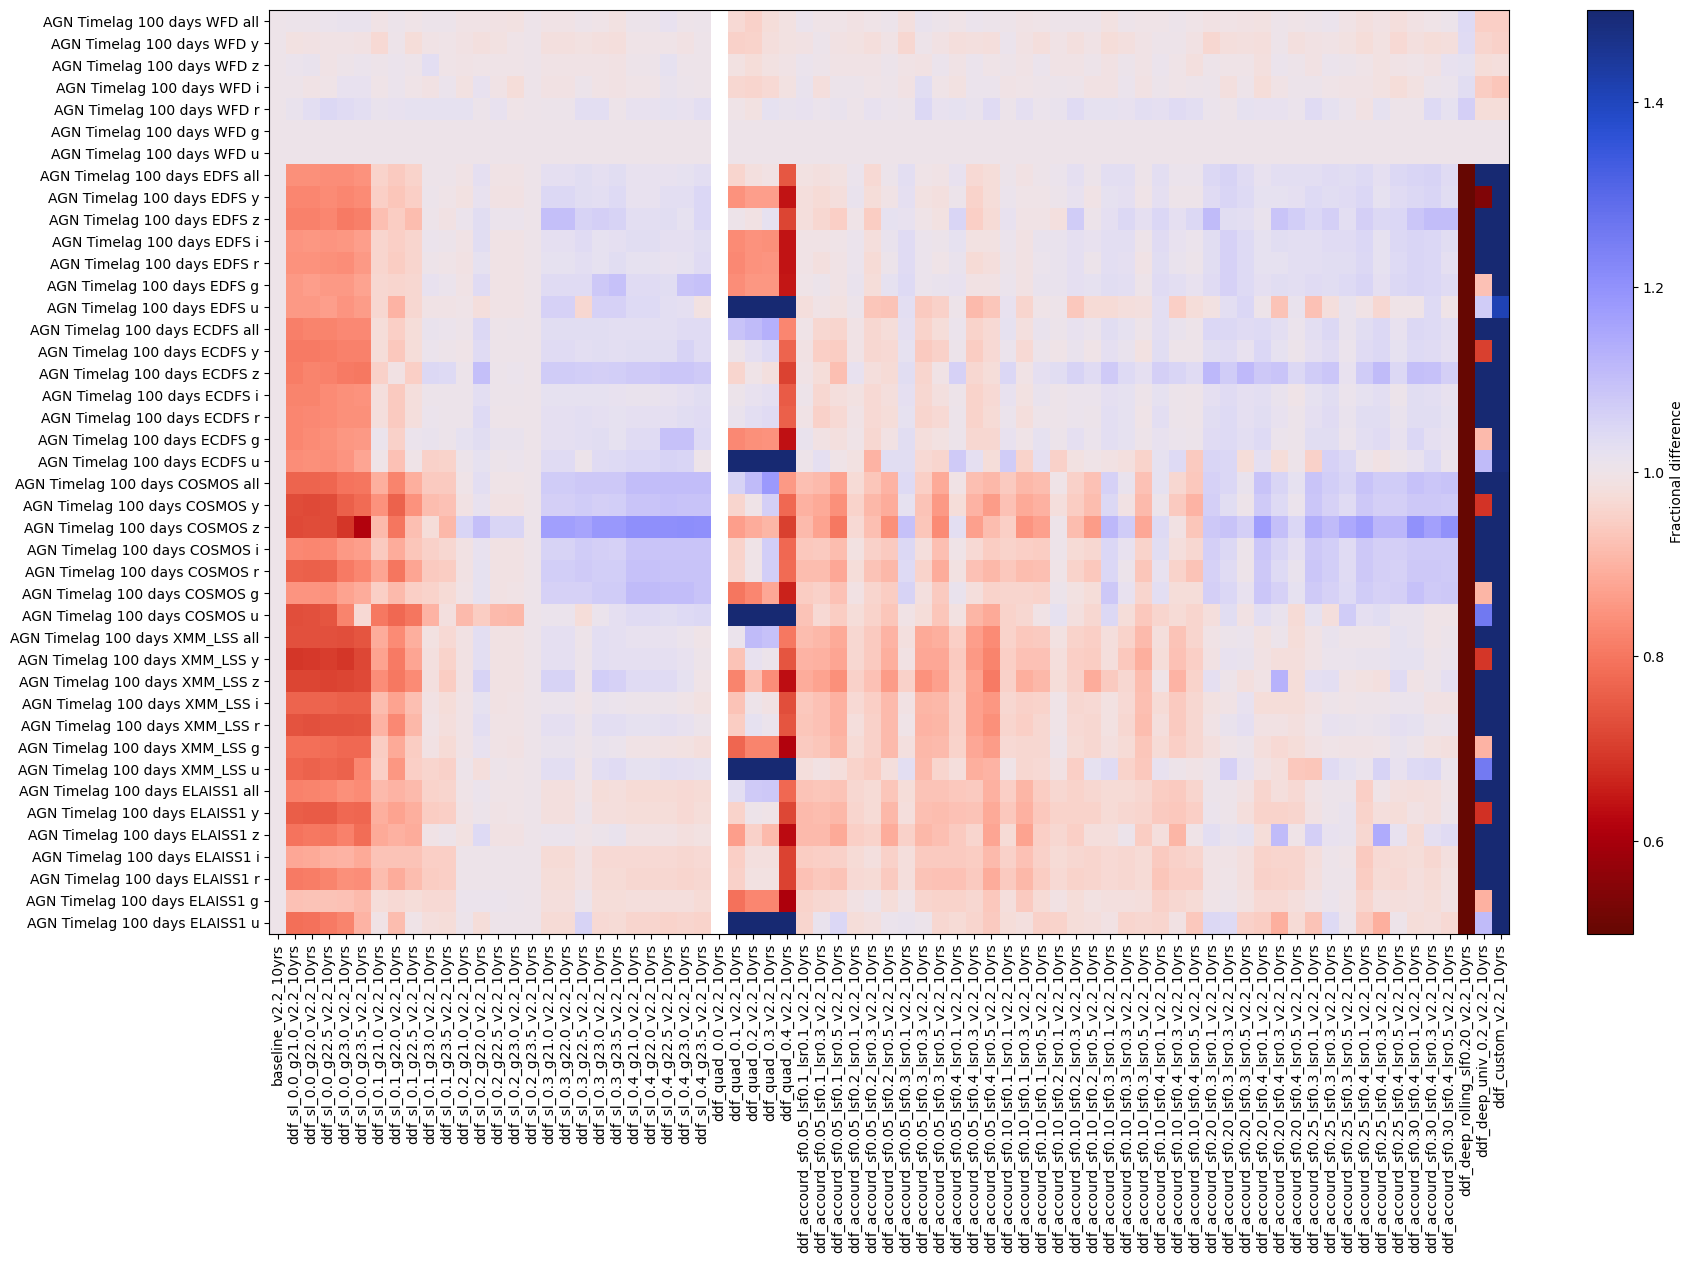

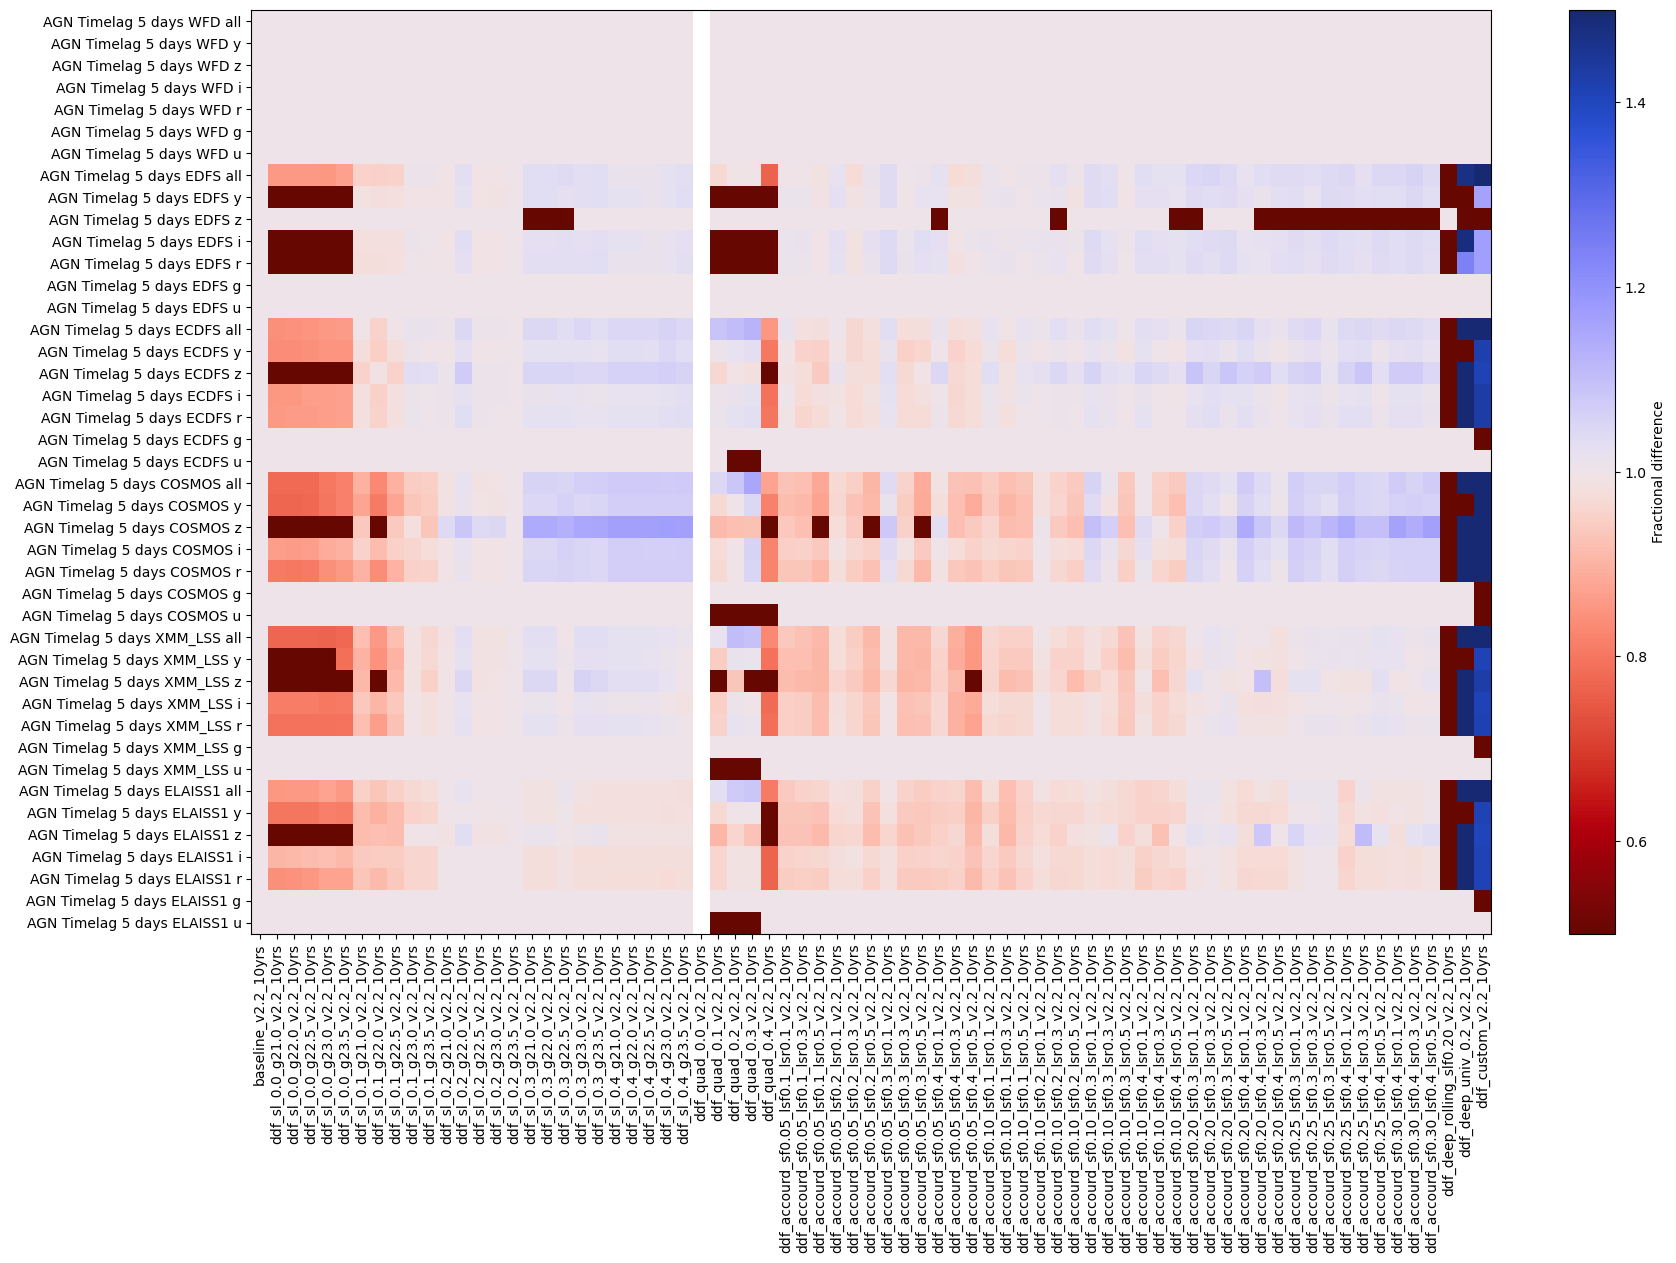

In [13]:
for m in ['AGN TimeLag 100 days DDF', 'AGN TimeLag 5 days DDF']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)

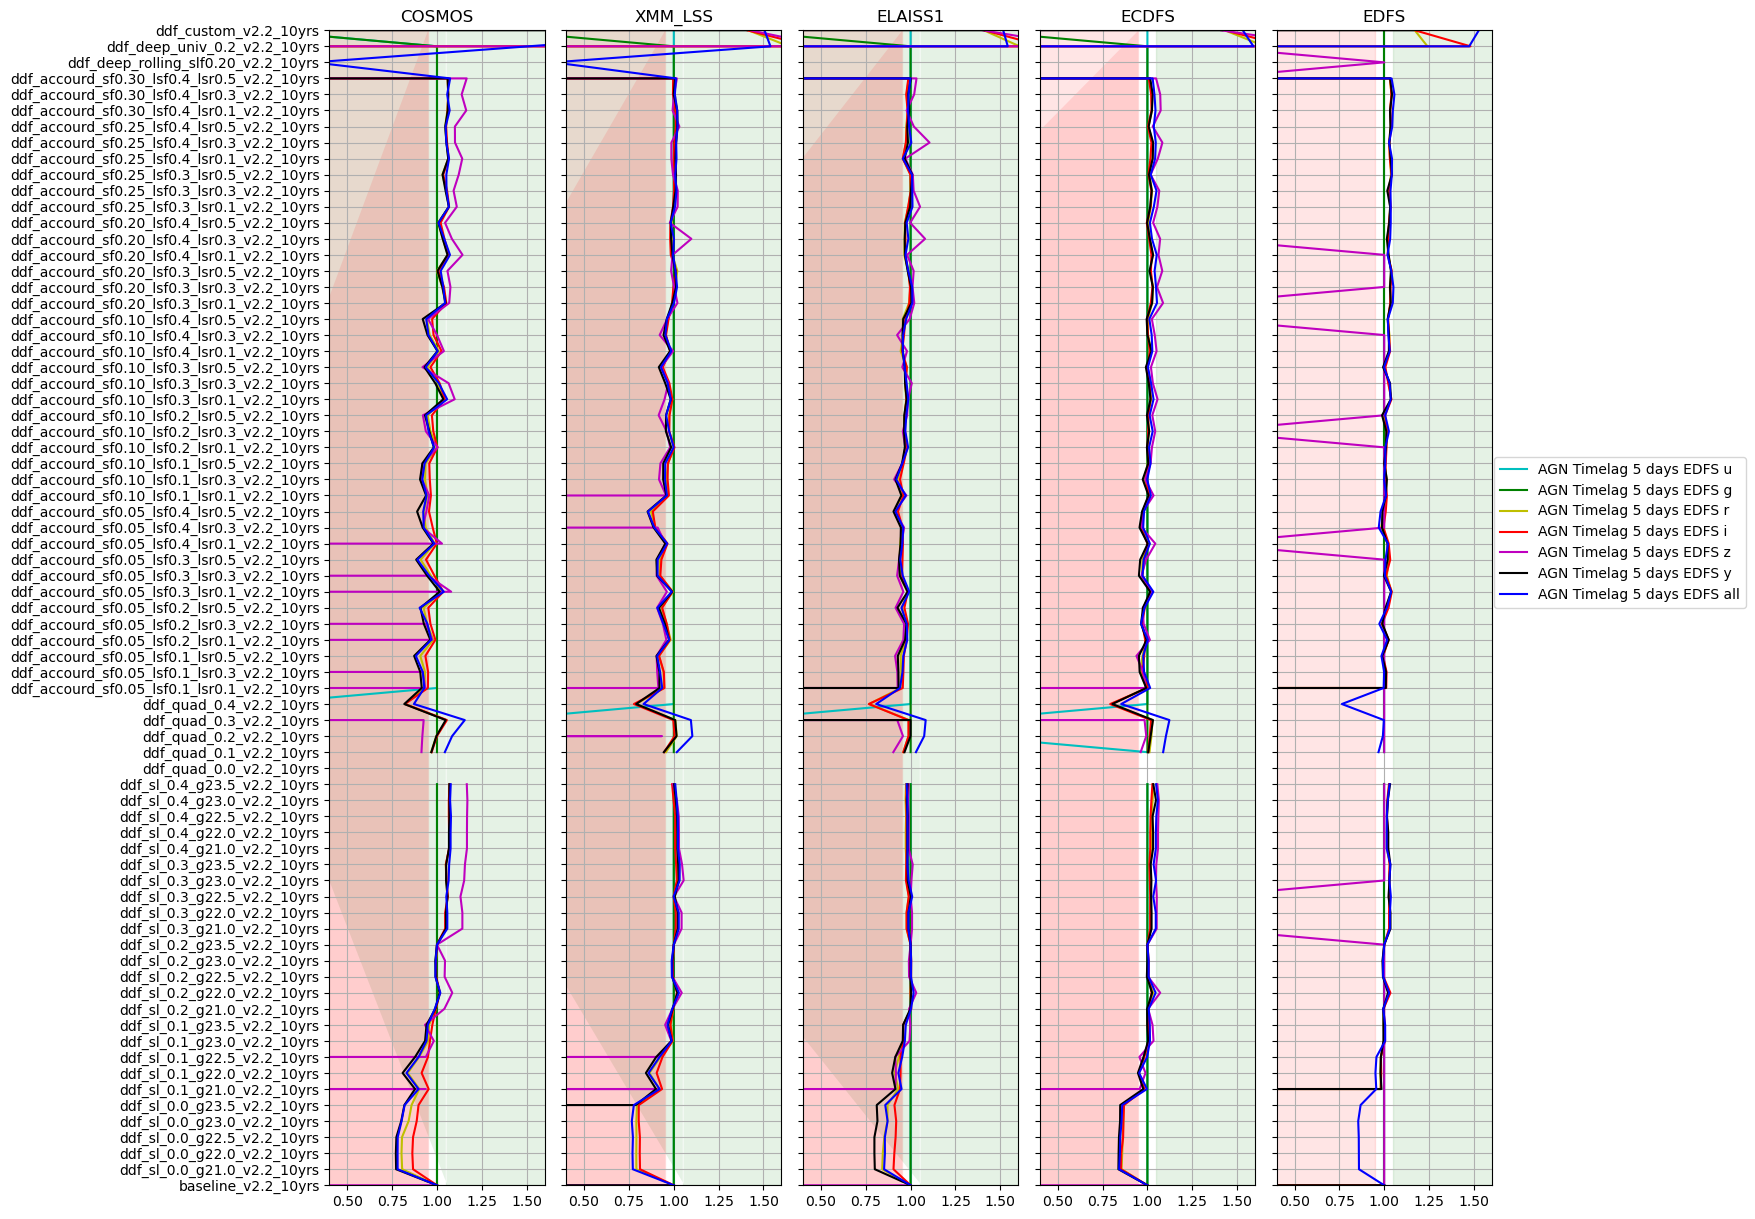

In [14]:
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']

fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = metrics.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

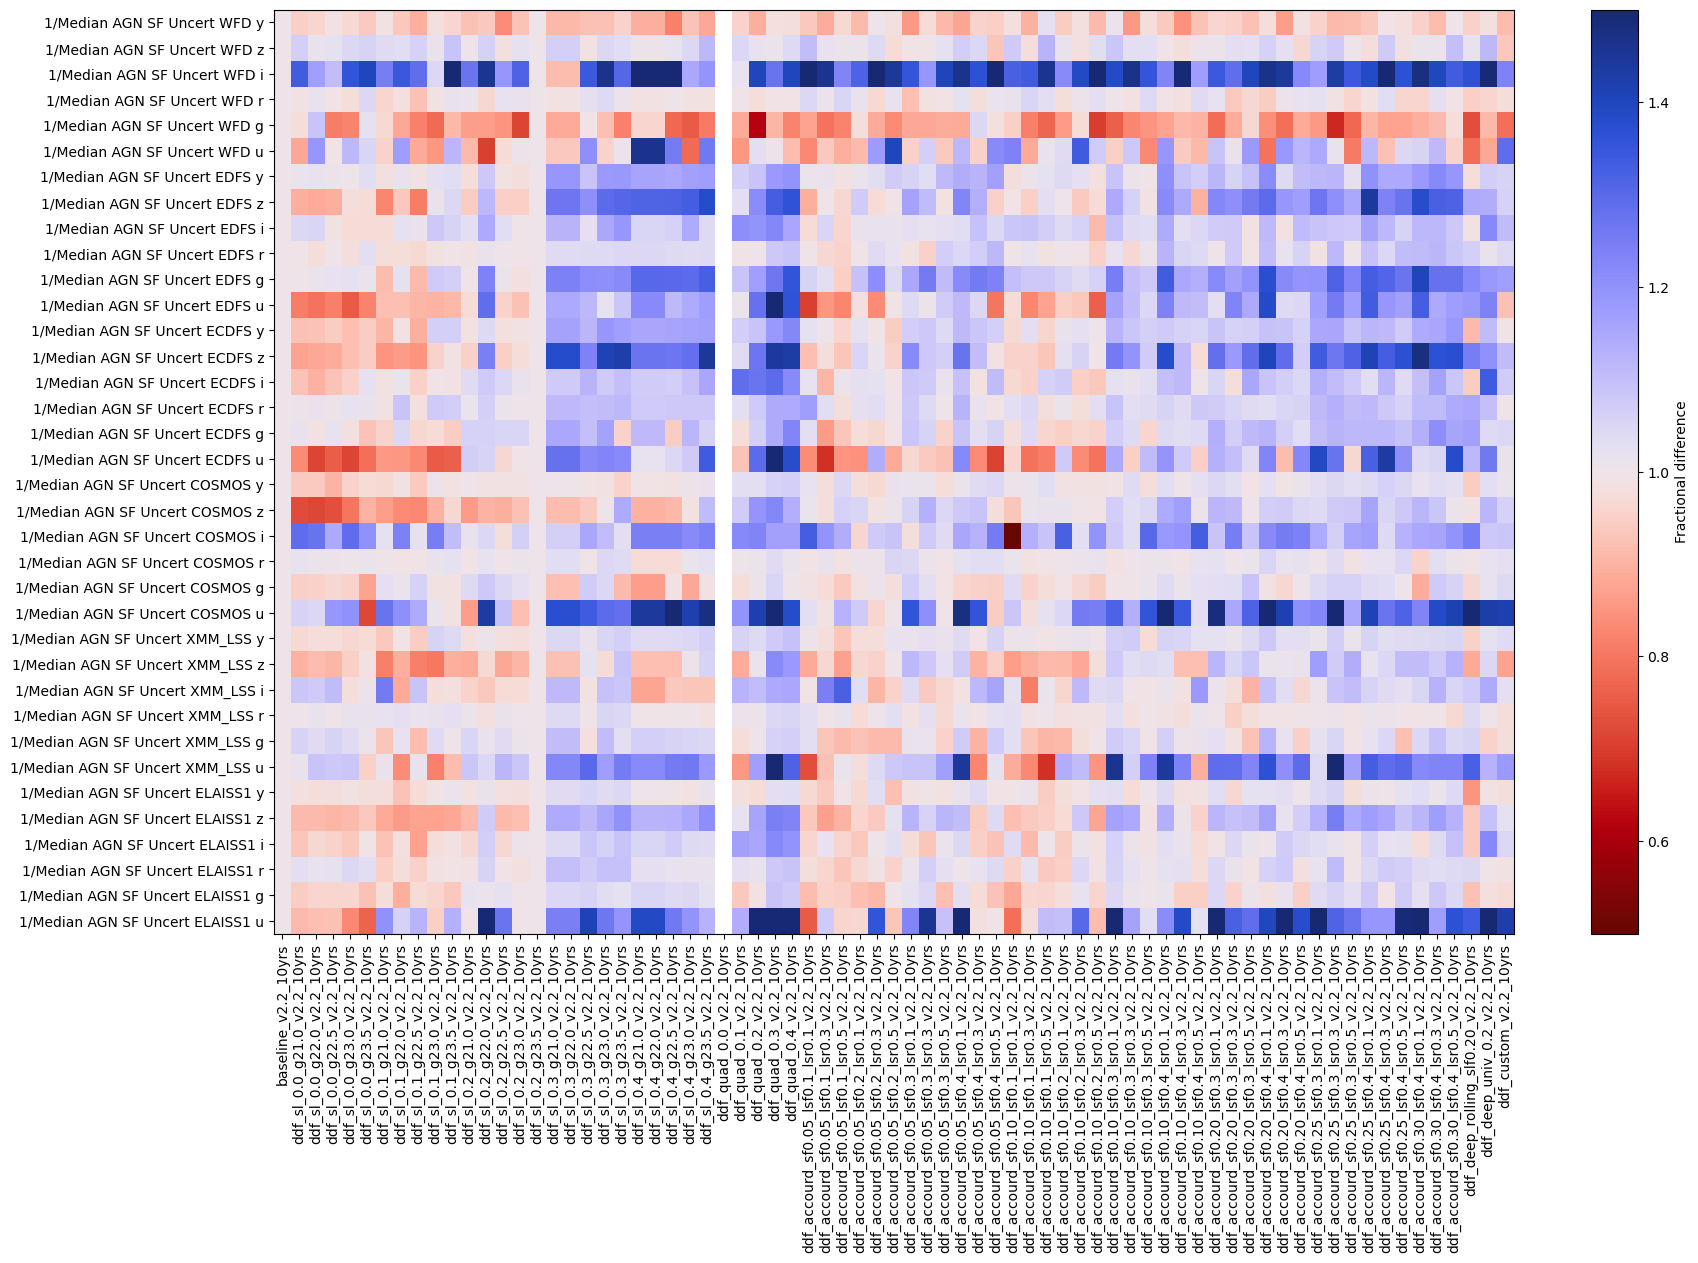

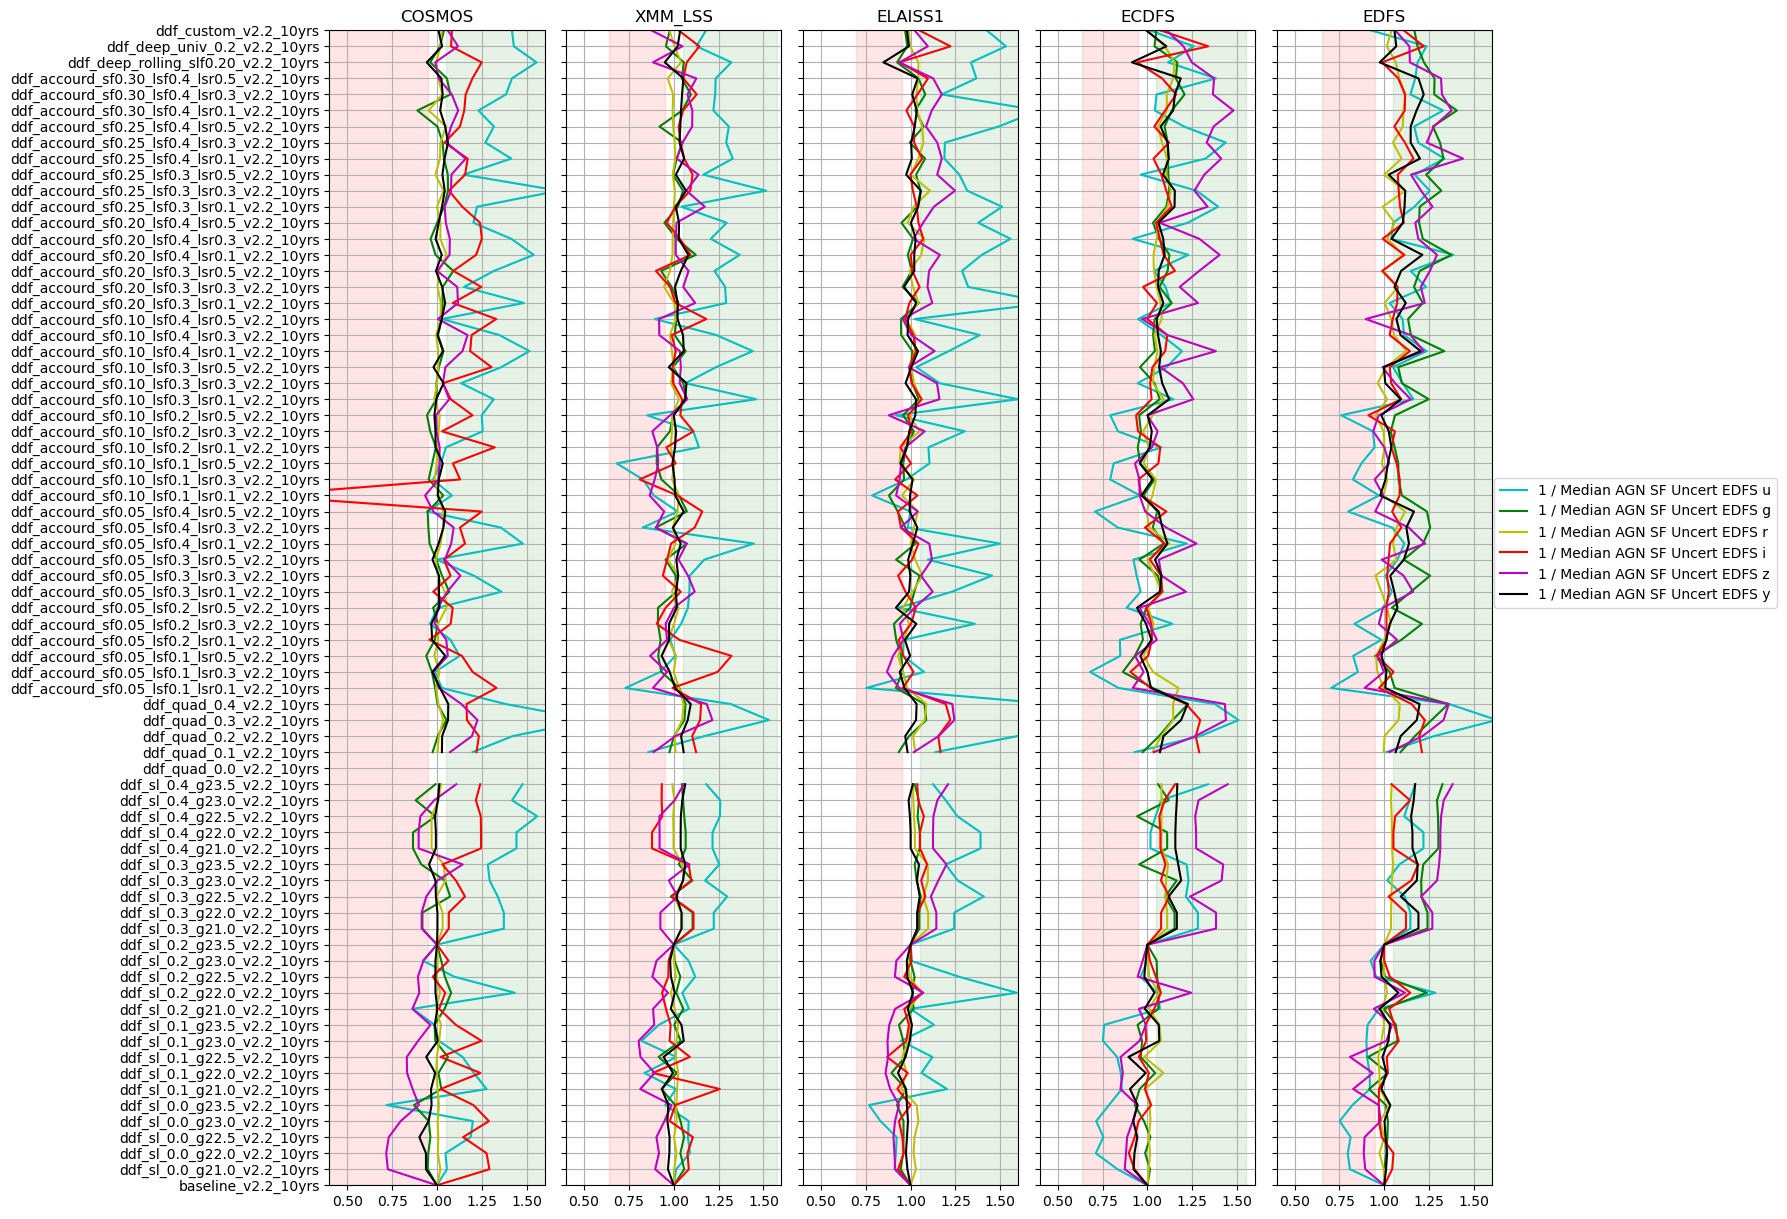

In [15]:
m = 'AGN SF DDF'
metrics = metric_sets.loc[m]
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)


fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = metrics.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

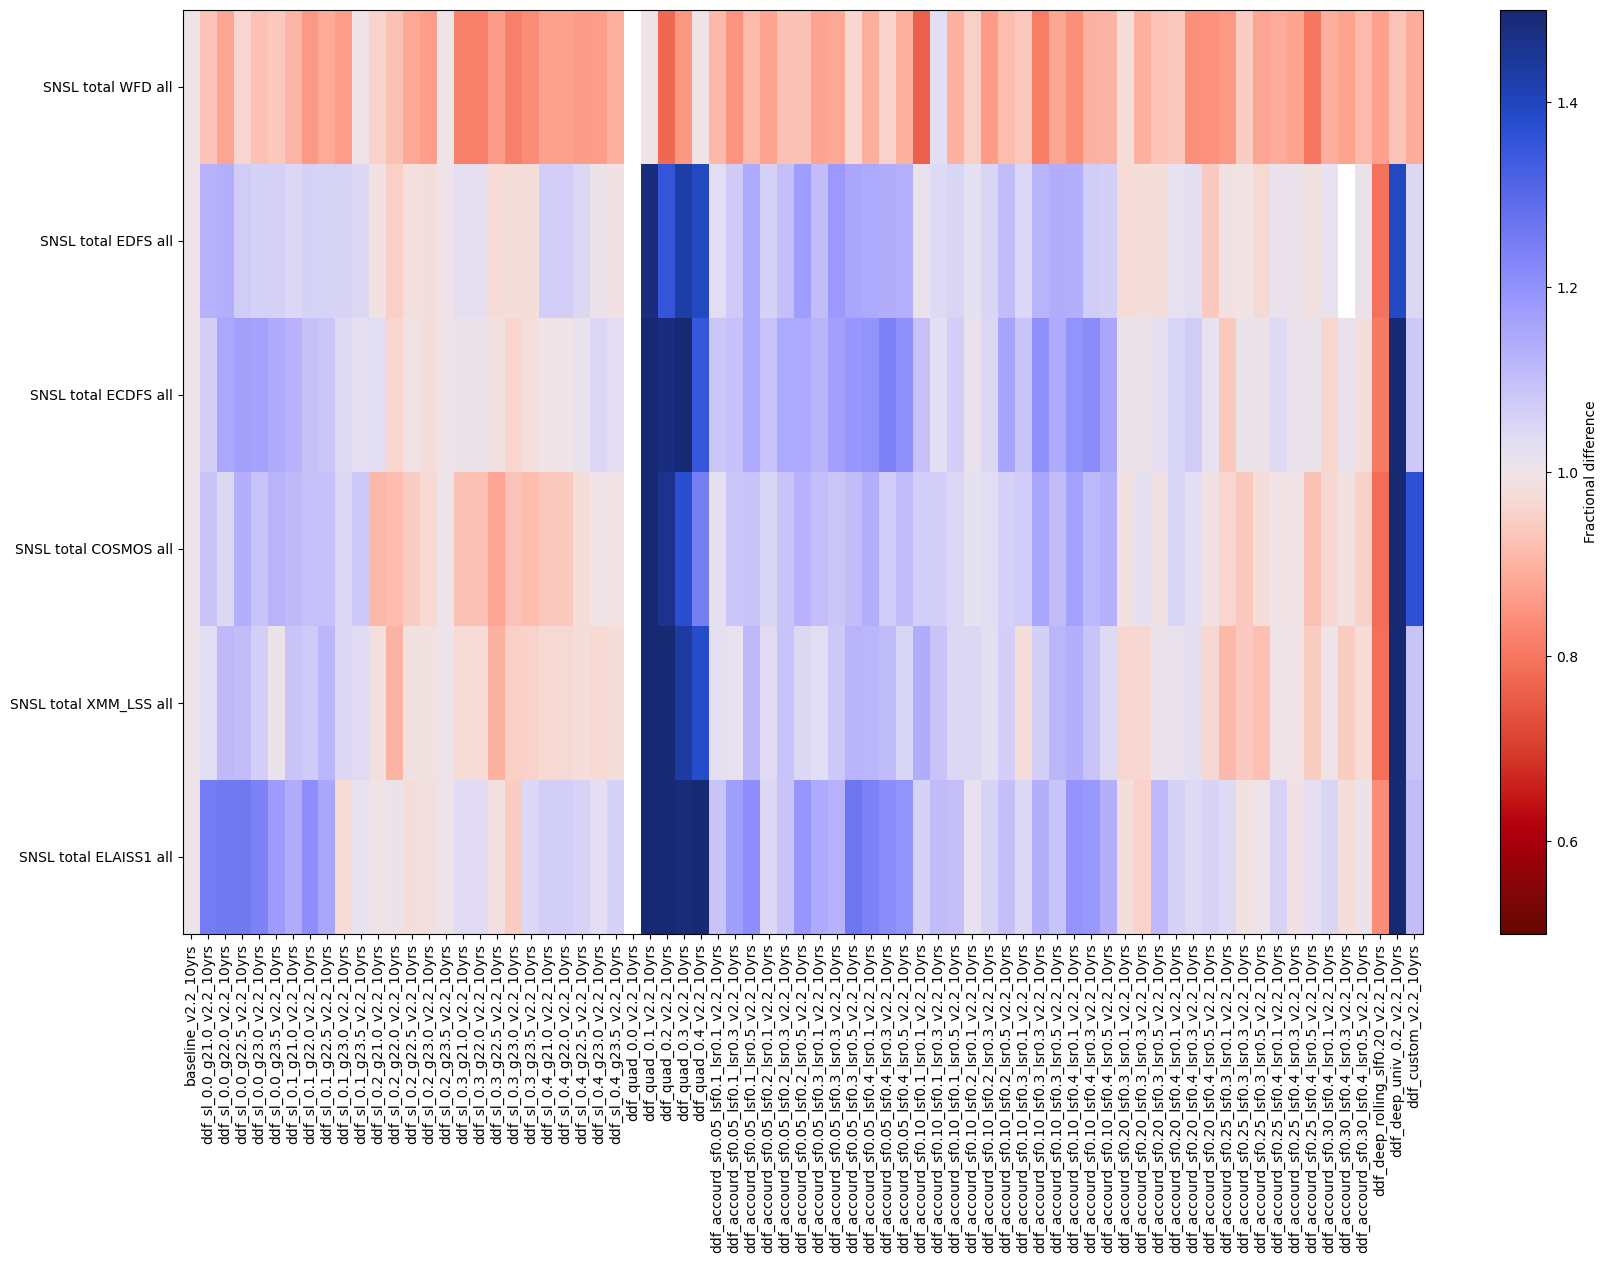

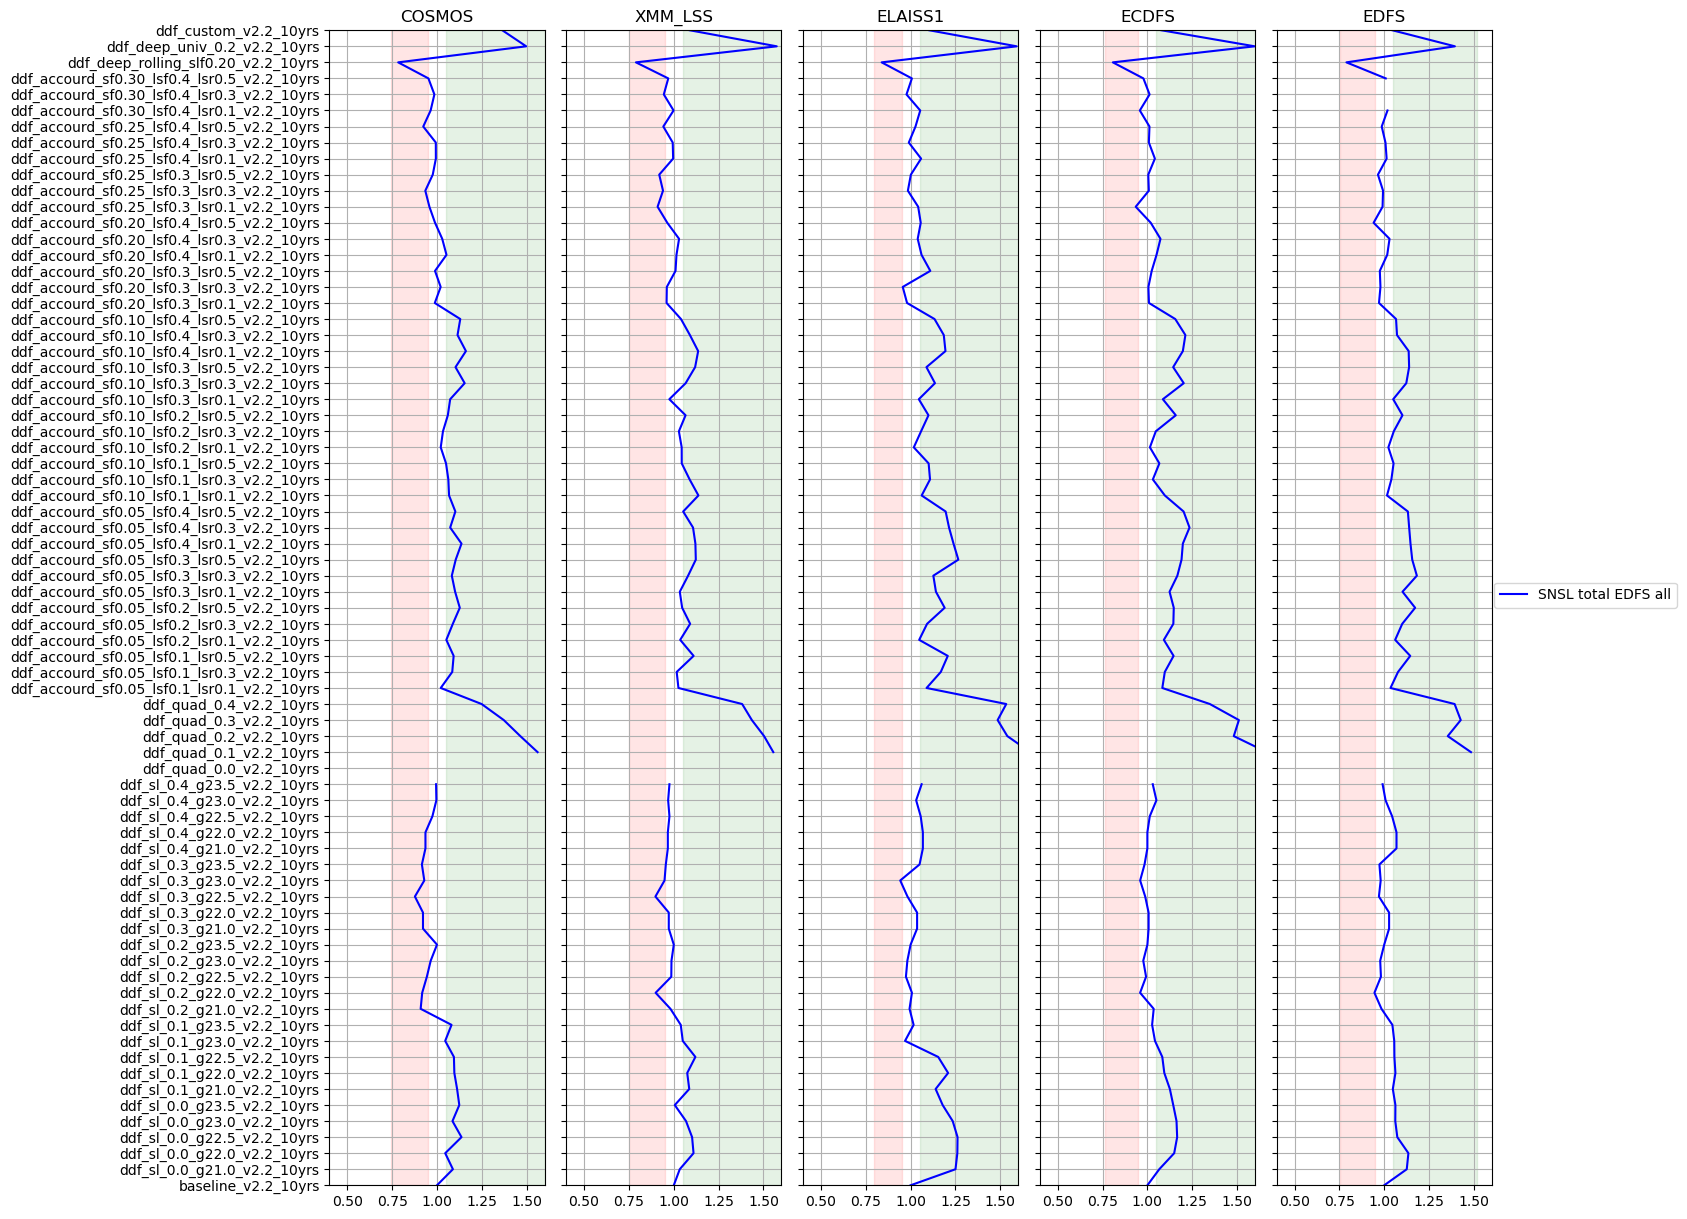

In [16]:
m = 'SNSL DDF'
metrics = metric_sets.loc[m]
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
    
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = metrics.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

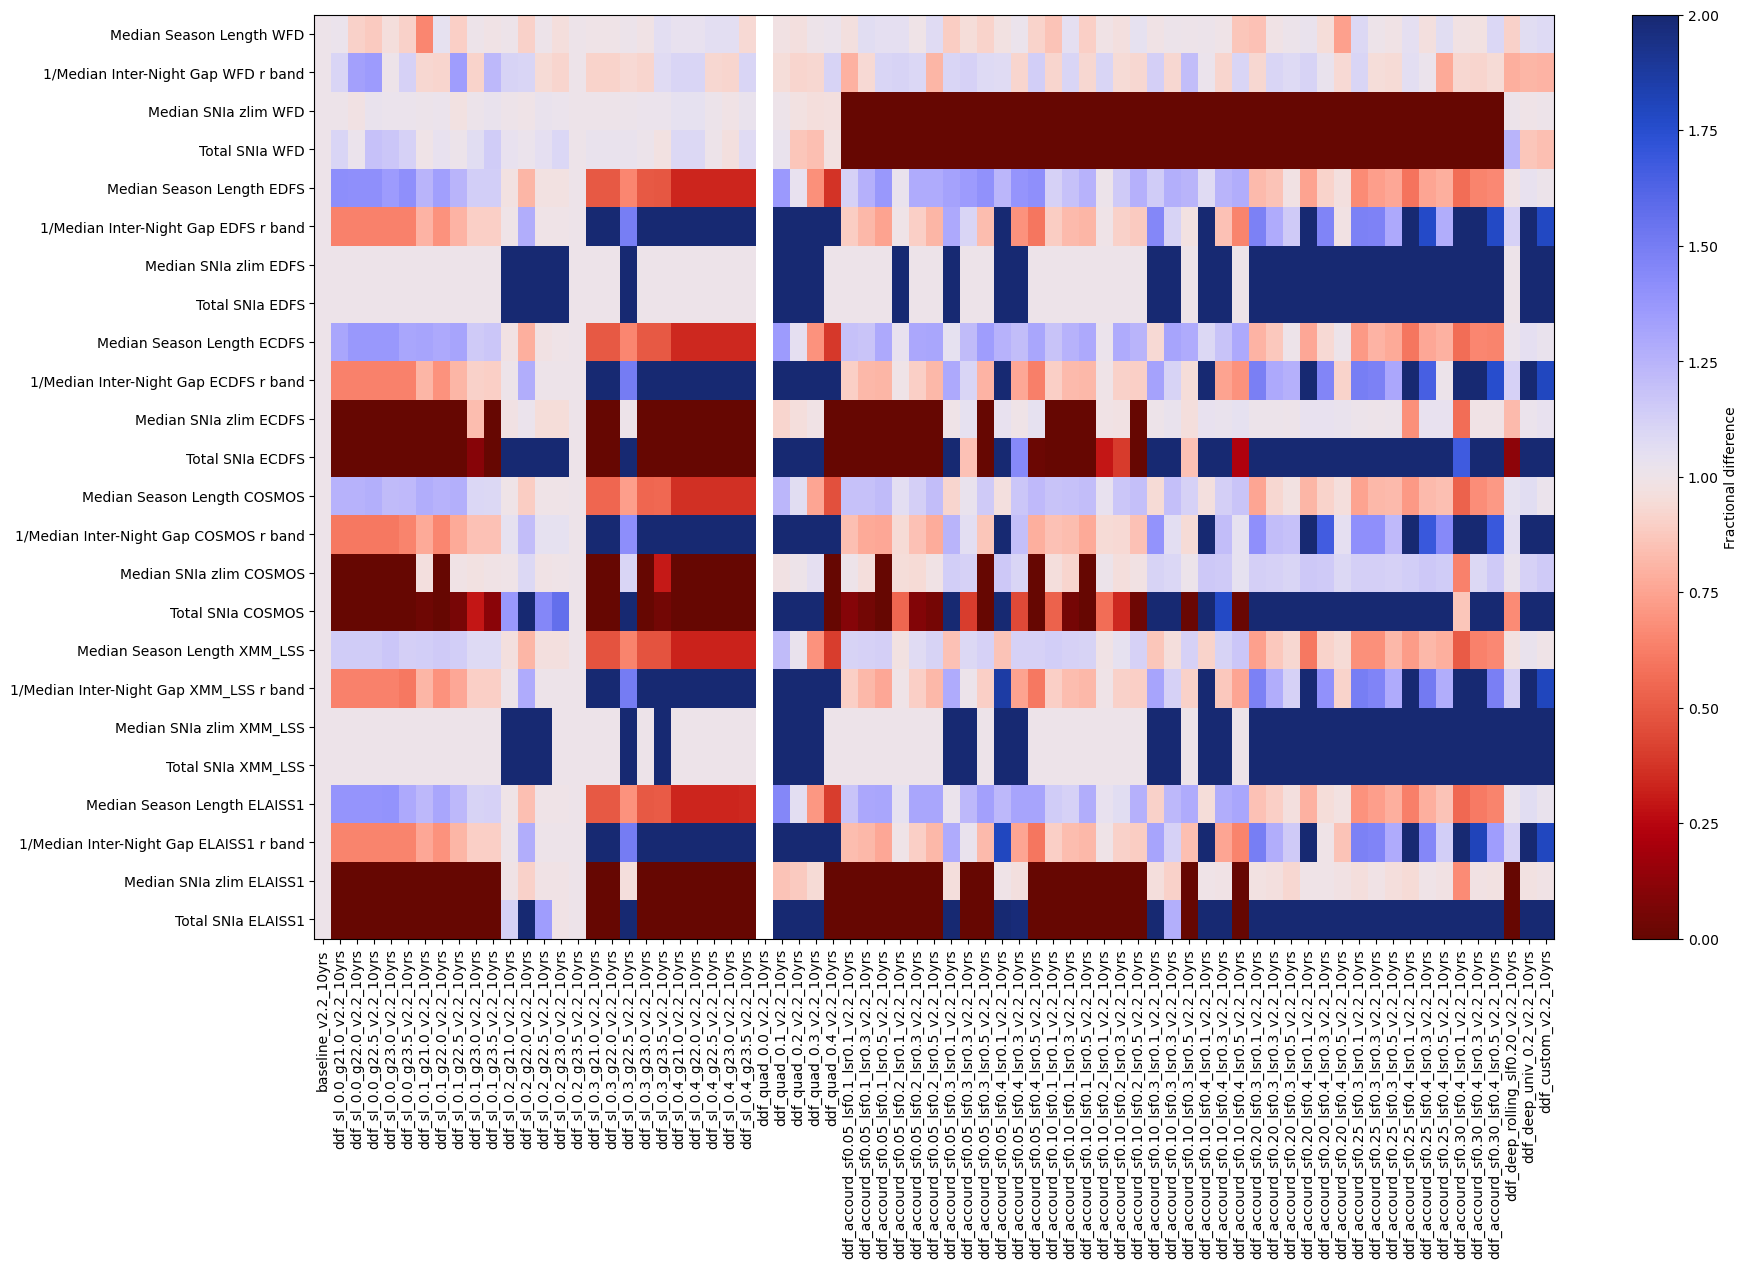

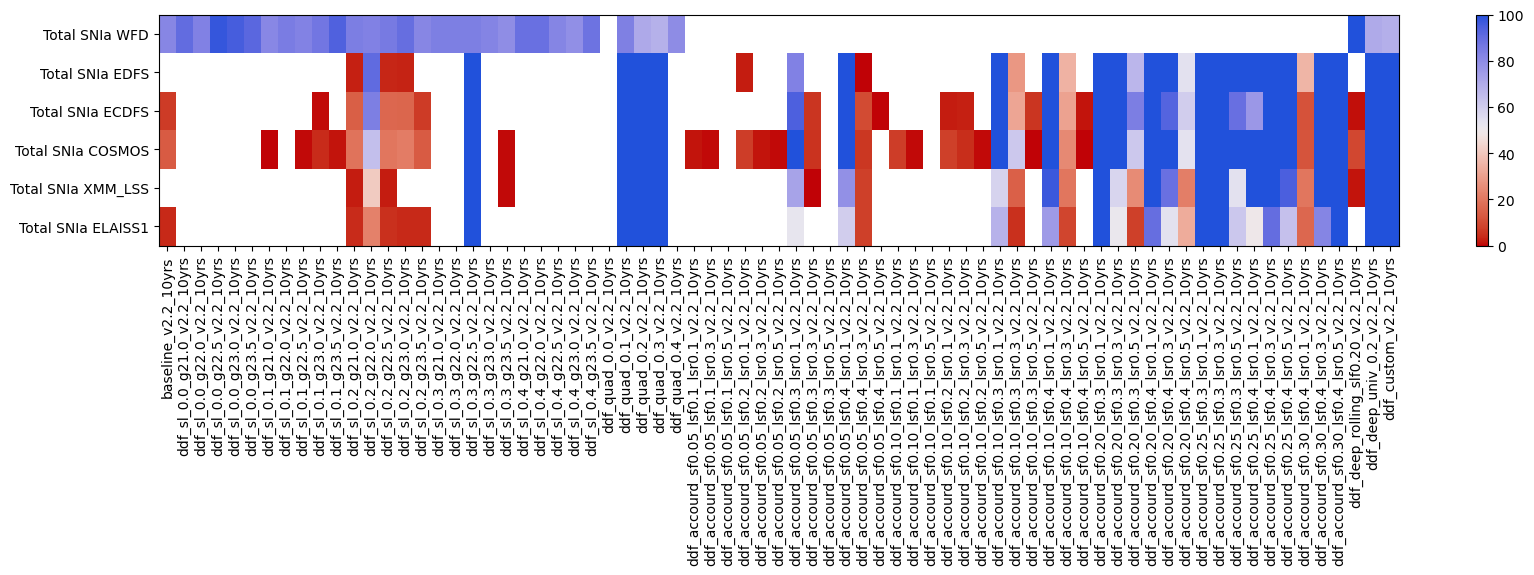

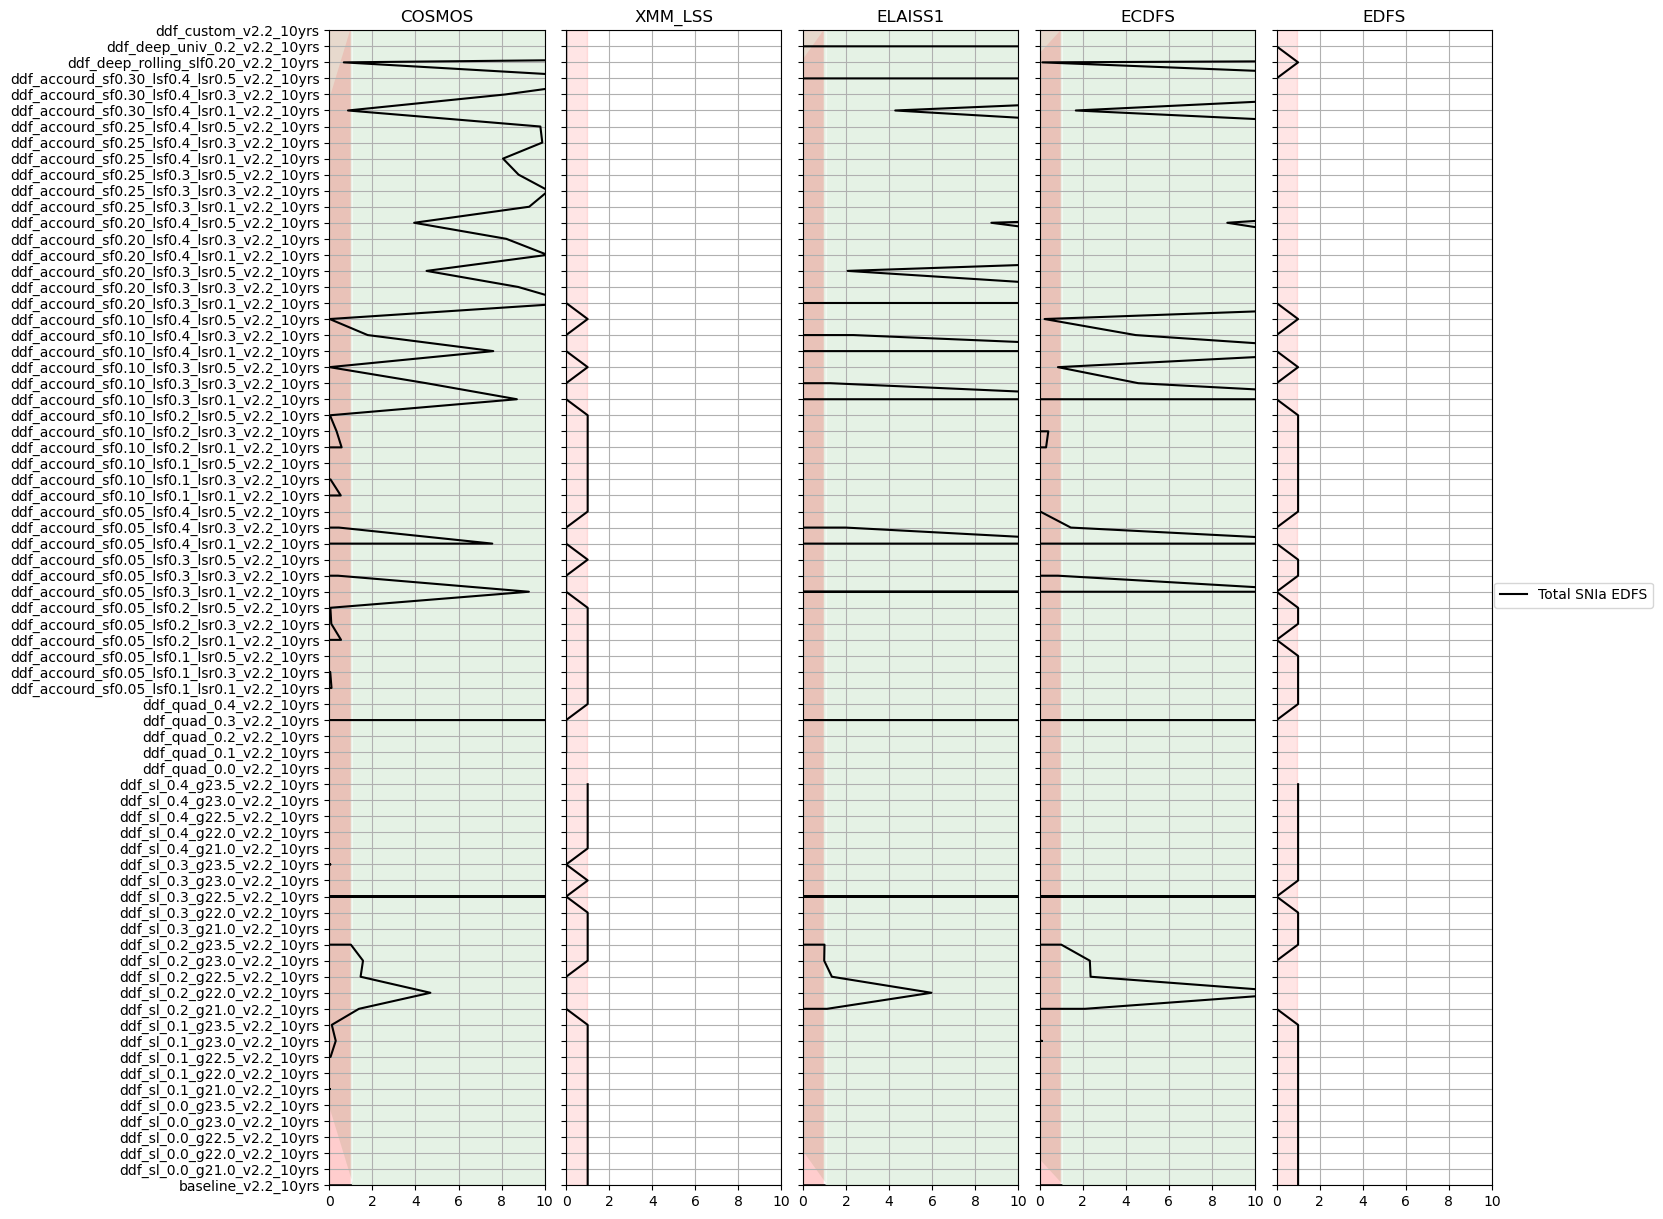

In [17]:
m = 'SNIa DDF'
metrics = metric_sets.loc[m]
t = summaries.loc[these_runs, metrics['metric']].copy()
t[t < 0] = 1e-30

fig, ax = maf.plot_run_metric_mesh(t.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=2)
fig.set_figwidth(20)
fig.set_figheight(12)
    
# replot just the SN, to show range of actual values
metrics = metric_sets.loc[m].query('metric.str.contains("Sum")', engine='python')
t = summaries.loc[these_runs, metrics['metric']].copy()
t[t < 0] = np.nan
fig, ax = maf.plot_run_metric_mesh(t.loc[these_runs, metrics['metric']],
                                  #baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                   cmap='cet_coolwarm_r',
                                  color_range=[0, 100])
fig.set_figwidth(20)
fig.set_figheight(3)
    
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = metrics.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.0, 10)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

metric                        Sum SNNSNMetric DD:ELAISS1_nSN DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                                     
ddf_quad_0.1_v2.2_10yrs                                              835.834458                         
ddf_quad_0.2_v2.2_10yrs                                              732.563907                         
ddf_quad_0.3_v2.2_10yrs                                              487.101432                         
ddf_deep_univ_0.2_v2.2_10yrs                                         974.863189                         
ddf_custom_v2.2_10yrs                                                455.556528                         

metric                        Median SNNSNMetric DD:ELAISS1_zlim DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                                         
ddf_quad_0.1_v2.2_10yrs                                                0.514967                             
ddf_quad_0.2_v2.2_10yrs                                                0.525191                             
ddf_quad_0.3_v2.2_10yrs                                                0.565551                             
ddf_deep_univ_0.2_v2.2_10yrs                                           0.584102                             
ddf_custom_v2.2_10yrs                                                  0.593593                             

metric                        Mean DD:ELAISS1 Median Inter-Night Gap r band UserPointsSlicer  \
run                                                                                            
ddf_quad_0.1_v2.2_10yrs                                                2.998106                
ddf_quad_0.2_v2.2_10yrs                                                2.000165                
ddf_quad_0.3_v2.2_10yrs                                                1.116254                
ddf_deep_univ_0.2_v2.2_10yrs                                           1.996789                
ddf_custom_v2.2_10yrs                                                  4.997330                

metric                        Mean DD:ELAISS1 Median Season Length all bands UserPointsSlicer  \
run                                                                                             
ddf_quad_0.1_v2.2_10yrs                                              293.652840                 
ddf_quad_0.2_v2.2_10yrs                                              214.636363                 
ddf_quad_0.3_v2.2_10yrs                                              142.896353                 
ddf_deep_univ_0.2_v2.2_10yrs                                         215.639095                 
ddf_custom_v2.2_10yrs                                                208.646004                 

metric                        Sum SNNSNMetric DD:XMM_LSS_nSN DD:XMM_LSS all bands HealpixSubsetSlicer  \
run                                                                                                     
ddf_quad_0.1_v2.2_10yrs                                              659.889590                         
ddf_quad_0.2_v2.2_10yrs                                              751.522328                         
ddf_quad_0.3_v2.2_10yrs                                              470.307636                         
ddf_deep_univ_0.2_v2.2_10yrs                                        1026.744287                         
ddf_custom_v2.2_10yrs                                                429.189929                         

metric                        Median SNNSNMetric DD:XMM_LSS_zlim DD:XMM_LSS all bands HealpixSubsetSlicer  \
run                                                                                                         
ddf_quad_0.1_v2.2_10yrs                                                0.502901                             
ddf_quad_0.2_v2.2_10yrs                                                0.518196     

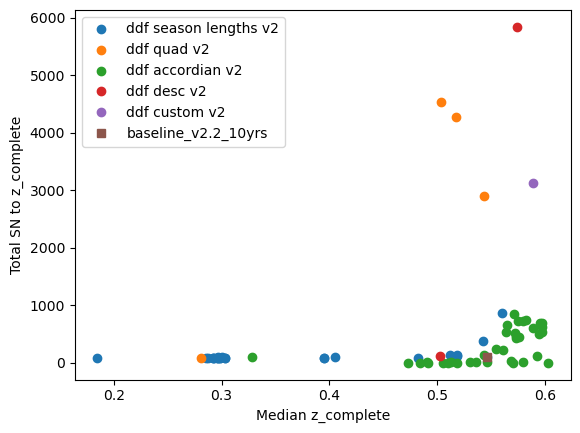

In [18]:
# Total number of SN?
m = 'SNIa DDF'
metrics = metric_sets.loc[m].query('metric.str.contains("Sum")', engine='python')
t = summaries.loc[these_runs, metrics['metric']].copy()
t[t < 0] = 0
sum_sn = t.T.sum()
metrics = metric_sets.loc[m].query('metric.str.contains("zlim")', engine='python')
t = summaries.loc[these_runs, metrics['metric']].copy()
t[t < 0] = np.nan
med_z = t.T.median()

for fam in ddf_fams['v2.2 cadence']:
    runs = families.explode('run').loc[fam, 'run']
    plt.plot(med_z.loc[runs], sum_sn.loc[runs], 
             linestyle='', marker='o', label=fam)
plt.plot(med_z.loc[baseline], sum_sn.loc[baseline], linestyle='', marker='s', label=baseline)
plt.legend()
plt.xlabel("Median z_complete")
plt.ylabel("Total SN to z_complete")

best = np.where(sum_sn > 2000)
summaries.loc[these_runs, metric_sets.loc[m]['metric']].iloc[best]

metric                                 Sum SNNSNMetric DD:ELAISS1_nSN DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                                              
ddf_quad_slf0.10_v2.1_10yrs                                                   785.535310                         
ddf_quad_slf0.15_v2.1_10yrs                                                   710.231545                         
ddf_quad_slf0.20_v2.1_10yrs                                                   645.922569                         
ddf_quad_slf0.25_v2.1_10yrs                                                   569.032886                         
ddf_quad_slf0.30_v2.1_10yrs                                                   444.668059                         
ddf_bright_slf0.10_v2.1_10yrs                                                 776.968584                         
ddf_bright_slf0.15_v2.1_10yrs                                                 681.019982                         
ddf_bright_slf0.20_v2.1_10yrs                                                 625.369862                         
ddf_bright_slf0.25_v2.1_10yrs                                                 541.980511                         
ddf_bright_slf0.30_v2.1_10yrs                                                 426.221326                         
ddf_quad_subfilter_slf0.10_v2.1_10yrs                                         470.710147                         
ddf_quad_subfilter_slf0.15_v2.1_10yrs                                         453.168411                         
ddf_quad_subfilter_slf0.20_v2.1_10yrs                                         423.327749                         
ddf_quad_subfilter_slf0.25_v2.1_10yrs                                         371.545908                         

metric                                 Median SNNSNMetric DD:ELAISS1_zlim DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                                                  
ddf_quad_slf0.10_v2.1_10yrs                                                     0.488175                             
ddf_quad_slf0.15_v2.1_10yrs                                                     0.480156                             
ddf_quad_slf0.20_v2.1_10yrs                                                     0.500694                             
ddf_quad_slf0.25_v2.1_10yrs                                                     0.507698                             
ddf_quad_slf0.30_v2.1_10yrs                                                     0.519346                             
ddf_bright_slf0.10_v2.1_10yrs                                                   0.482771                             
ddf_bright_slf0.15_v2.1_10yrs                                                   0.471631                             
ddf_bright_slf0.20_v2.1_10yrs                                                   0.490772                             
ddf_bright_slf0.25_v2.1_10yrs                                                   0.497714                             
ddf_bright_slf0.30_v2.1_10yrs                                                   0.509911                             
ddf_quad_subfilter_slf0.10_v2.1_10yrs                                           0.417047                             
ddf_quad_subfilter_slf0.15_v2.1_10yrs                                           0.425970                             
ddf_quad_subfilter_slf0.20_v2.1_10yrs                                           0.438665                             
ddf_quad_subfilter_slf0.25_v2.1_10yrs                                           0.449519                             

metric                                 Mean DD:ELAISS1 Median Inter-Night Gap r band UserPointsSlicer  \
run                                                                                                     
ddf_quad_slf0.10_v2.1_10yrs                                                 

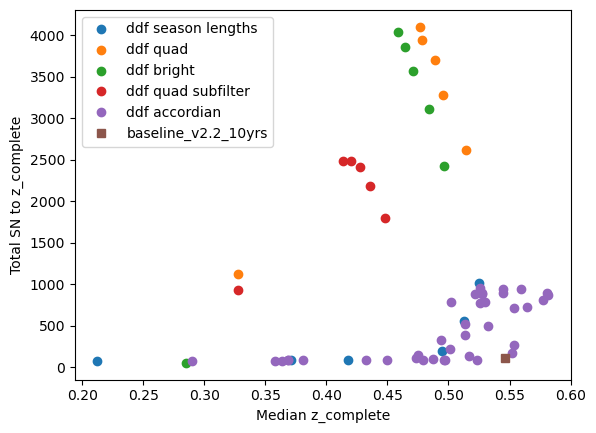

In [19]:
# Can we reproduce DESC's plot from v2.1 runs? 
# Total number of SN?
m = 'SNIa DDF'
v21_runs = np.concatenate([[baseline], families.explode('run').loc[ddf_fams['v2.1 cadence'], 'run']])
metrics = metric_sets.loc[m].query('metric.str.contains("Sum")', engine='python')
t = summaries.loc[v21_runs, metrics['metric']].copy()
t[t < 0] = 0
sum_sn = t.T.sum()
metrics = metric_sets.loc[m].query('metric.str.contains("zlim")', engine='python')
t = summaries.loc[v21_runs, metrics['metric']].copy()
t[t < 0] = np.nan
med_z = t.T.median()

for fam in ddf_fams['v2.1 cadence']:
    runs = families.explode('run').loc[fam, 'run']
    plt.plot(med_z.loc[runs], sum_sn.loc[runs], 
             linestyle='', marker='o', label=fam)
plt.plot(med_z.loc[baseline], sum_sn.loc[baseline], linestyle='', marker='s', label=baseline)
plt.legend()
plt.xlabel("Median z_complete")
plt.ylabel("Total SN to z_complete")

best = np.where(sum_sn > 2000)
summaries.loc[v21_runs, metric_sets.loc[m]['metric']].iloc[best]

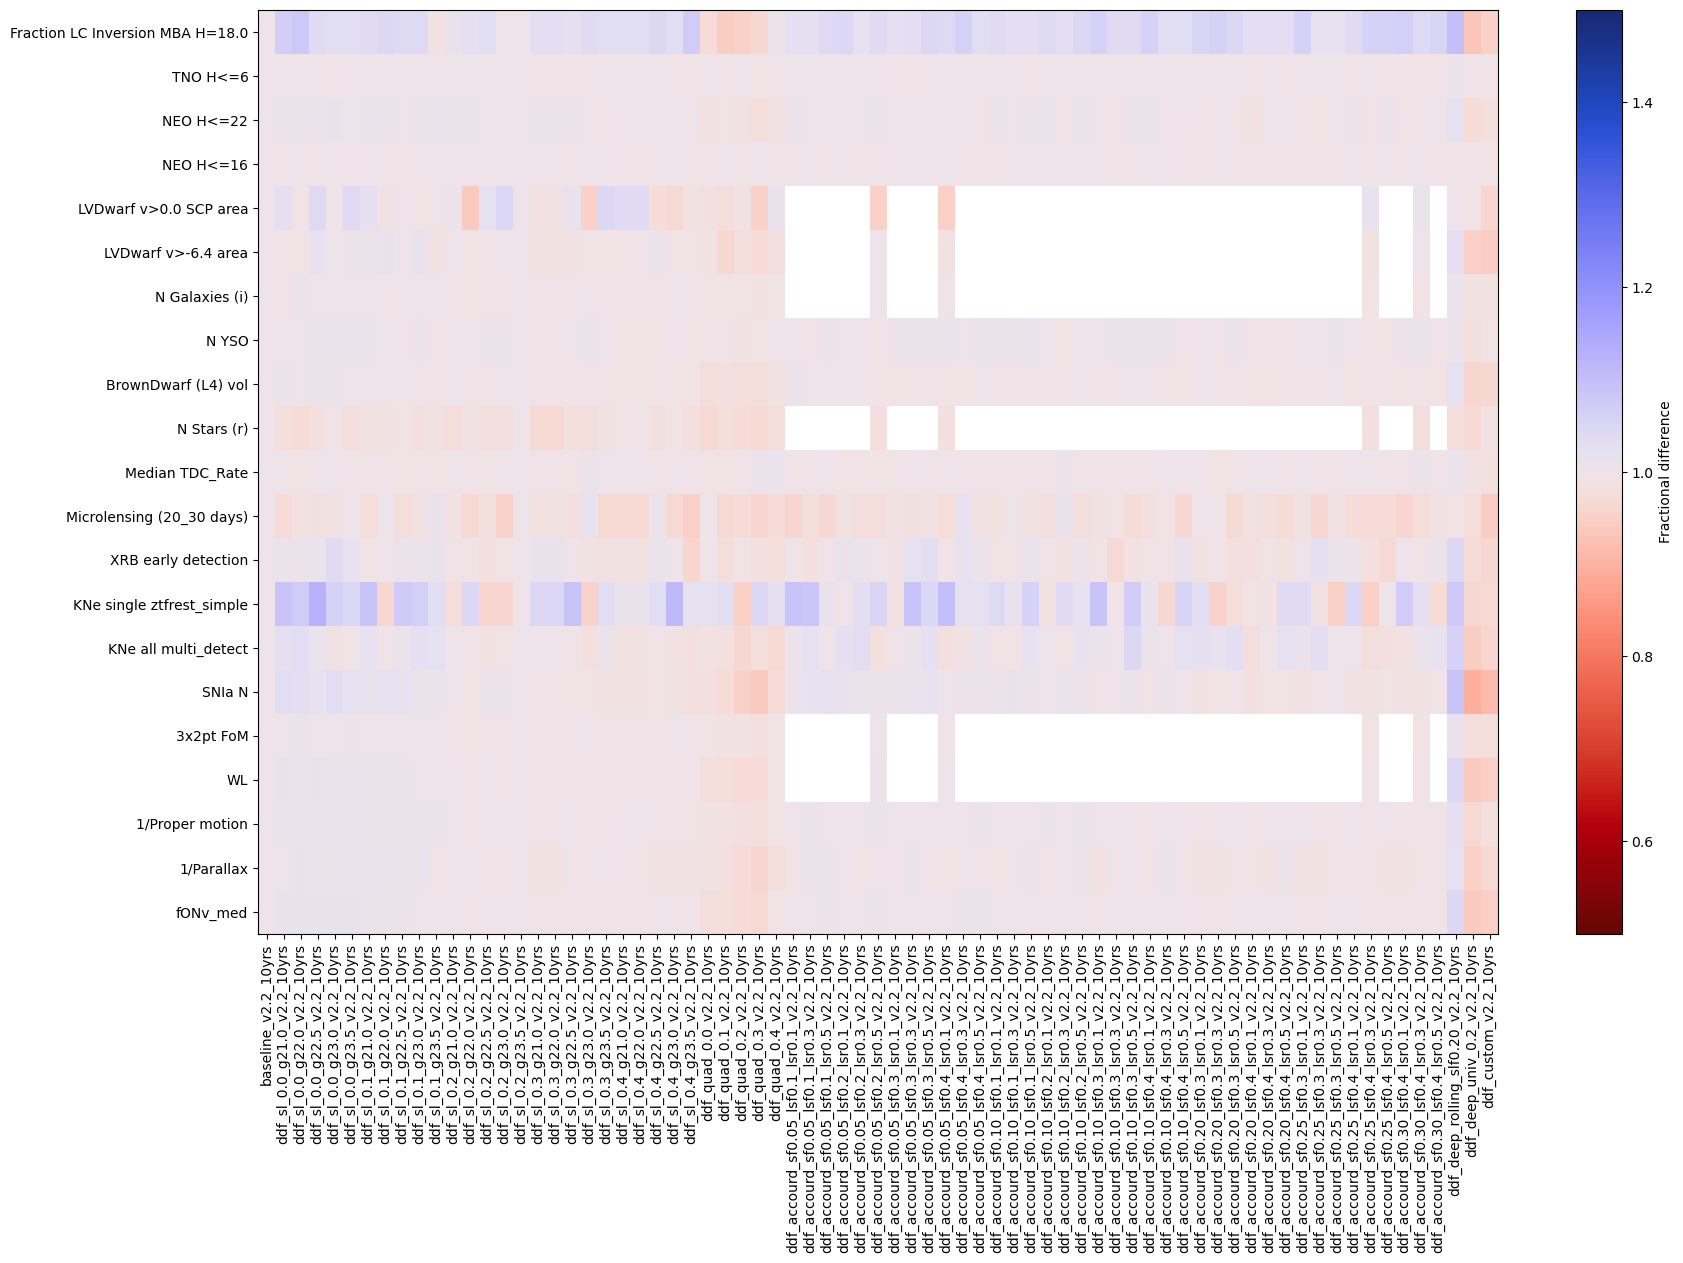

In [20]:
for m in ['SCOC']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)

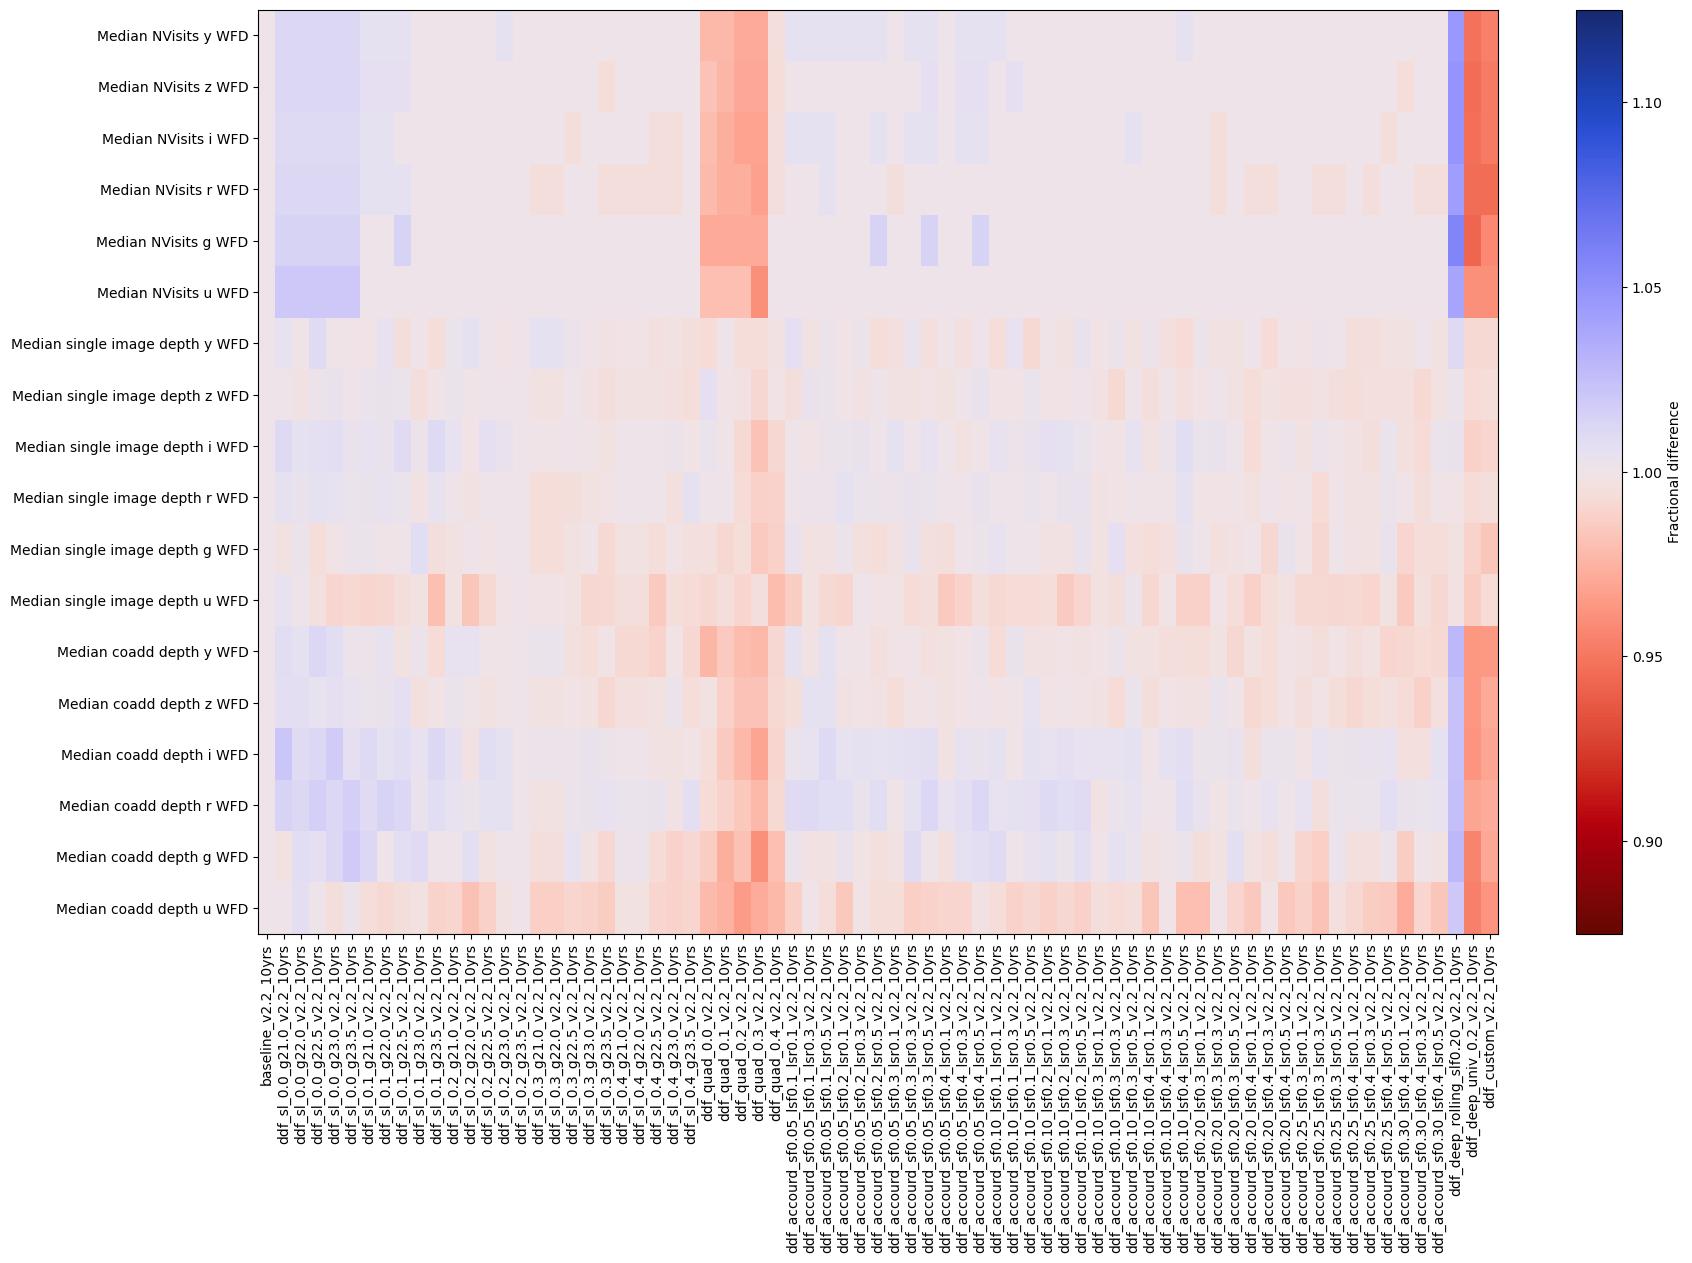

In [21]:
for m in ['WFD Depths']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=0.25)
    fig.set_figwidth(20)
    fig.set_figheight(12)